## Описание проекта Интернет магазин

Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.

«В один клик» — современная компания, поэтому её руководство не хочет принимать решения просто так — только на основе анализа данных и бизнес-моделирования. У компании есть небольшой отдел цифровых технологий, и вам предстоит побыть в роли стажёра в этом отделе.

Итак, вашему отделу поручили разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

Продумывать подход к решению этой задачи вам не придётся — руководитель отдела его уже сформировал:

Нужно промаркировать уровень финансовой активности постоянных покупателей. В компании принято выделять два уровня активности: «снизилась», если клиент стал покупать меньше товаров, и «прежний уровень».

Нужно собрать данные по клиентам по следующим группам:

Признаки, которые описывают коммуникацию сотрудников компании с клиентом.

Признаки, которые описывают продуктовое поведение покупателя. Например, какие товары покупает и как часто.

Признаки, которые описывают покупательское поведение клиента. Например, сколько тратил в магазине.

Признаки, которые описывают поведение покупателя на сайте. Например, как много страниц просматривает и сколько времени проводит на сайте.

In [1]:
!pip install phik -q

!pip install scikit-learn==1.1.3 -q

!pip install shap -q

In [2]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None

import seaborn as sns
from matplotlib import pyplot as plt

from phik.report import correlation_report, plot_correlation_matrix

from sklearn.compose import make_column_transformer
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from sklearn.linear_model import(
    Ridge,
    LogisticRegression,
) 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    mean_squared_error,
    roc_curve,
    roc_auc_score,
    f1_score
)
    
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    train_test_split
)

from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
    MinMaxScaler,
    RobustScaler,
    LabelEncoder
)

import shap
from sklearn.feature_selection import SelectKBest, f_classif

from shap import Explanation, KernelExplainer
from shap.plots import waterfall, beeswarm

RANDOM_STATE = 42
TEST_SIZE = 0.25

### Шаг 1. Загрузка данных

In [3]:
try:
    market_file = pd.read_csv('/datasets/market_file.csv', sep=',')
    market_money = pd.read_csv('/datasets/market_money.csv', sep=',')
    market_time = pd.read_csv('/datasets/market_time.csv', sep=',')
    money = pd.read_csv('/datasets/money.csv', sep=';')

except:
    market_file = pd.read_csv('https://code.s3.yandex.net/datasets/market_file.csv', sep=',')
    market_money = pd.read_csv('https://code.s3.yandex.net/datasets/market_money.csv', sep=',')
    market_time = pd.read_csv('https://code.s3.yandex.net/datasets/market_time.csv', sep=',')
    money = pd.read_csv('https://code.s3.yandex.net/datasets/money.csv', sep=';')
    

In [4]:
def data_info(data):
    pd.set_option('display.max_columns', None)
    display(data.head())
    display(data.describe(include='all'))
    data.info()

In [5]:
data_info(market_file)

id Покупательская активность Тип сервиса Разрешить сообщать  \
0  215348                 Снизилась     премиум                 да   
1  215349                 Снизилась     премиум                 да   
2  215350                 Снизилась   стандартт                нет   
3  215351                 Снизилась   стандартт                 да   
4  215352                 Снизилась   стандартт                нет   

   Маркет_актив_6_мес  Маркет_актив_тек_мес  Длительность  Акционные_покупки  \
0                 3.4                     5           121               0.00   
1                 4.4                     4           819               0.75   
2                 4.9                     3           539               0.14   
3                 3.2                     5           896               0.99   
4                 5.1                     3          1064               0.94   

  Популярная_категория  Средний_просмотр_категорий_за_визит  \
0     Товары для детей                                    6   
1     Товары для детей                                    4   
2    Домашний текстиль                                    5   
3     Товары для детей                                    5   
4     Товары для детей                                    3   

   Неоплаченные_продукты_штук_квартал  Ошибка_сервиса  Страниц_за_визит  
0                                   2               1                 5  
1                                   4               2                 5  
2                                   2               1                 5  
3                                   0               6                 4  
4                                   2               3                 2

id Покупательская активность Тип сервиса  \
count     1300.000000                      1300        1300   
unique            NaN                         2           3   
top               NaN           Прежний уровень    стандарт   
freq              NaN                       802         914   
mean    215997.500000                       NaN         NaN   
std        375.421985                       NaN         NaN   
min     215348.000000                       NaN         NaN   
25%     215672.750000                       NaN         NaN   
50%     215997.500000                       NaN         NaN   
75%     216322.250000                       NaN         NaN   
max     216647.000000                       NaN         NaN   

       Разрешить сообщать  Маркет_актив_6_мес  Маркет_актив_тек_мес  \
count                1300         1300.000000           1300.000000   
unique                  2                 NaN                   NaN   
top                    да                 NaN                   NaN   
freq                  962                 NaN                   NaN   
mean                  NaN            4.253769              4.011538   
std                   NaN            1.014814              0.696868   
min                   NaN            0.900000              3.000000   
25%                   NaN            3.700000              4.000000   
50%                   NaN            4.200000              4.000000   
75%                   NaN            4.900000              4.000000   
max                   NaN            6.600000              5.000000   

        Длительность  Акционные_покупки Популярная_категория  \
count    1300.000000        1300.000000                 1300   
unique           NaN                NaN                    6   
top              NaN                NaN     Товары для детей   
freq             NaN                NaN                  330   
mean      601.898462           0.319808                  NaN   
std       249.856289           0.249843                  NaN   
min       110.000000           0.000000                  NaN   
25%       405.500000           0.170000                  NaN   
50%       606.000000           0.240000                  NaN   
75%       806.000000           0.300000                  NaN   
max      1079.000000           0.990000                  NaN   

        Средний_просмотр_категорий_за_визит  \
count                            1300.00000   
unique                                  NaN   
top                                     NaN   
freq                                    NaN   
mean                                3.27000   
std                                 1.35535   
min                                 1.00000   
25%                                 2.00000   
50%                                 3.00000   
75%                                 4.00000   
max                                 6.00000   

        Неоплаченные_продукты_штук_квартал  Ошибка_сервиса  Страниц_за_визит  
count                          1300.000000     1300.000000       1300.000000  
unique                                 NaN             NaN               NaN  
top                                    NaN             NaN               NaN  
freq                                   NaN             NaN               NaN  
mean                              2.840000        4.185385          8.176923  
std                               1.971451        1.955298          3.978126  
min                               0.000000        0.000000          1.000000  
25%                               1.000000        3.000000          5.000000  
50%                               3.000000        4.000000          8.000000  
75%                               4.000000        6.000000         11.000000  
max                              10.000000        9.000000         20.000000

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

In [6]:
data_info(market_money)

id               Период  Выручка
0  215348  препредыдущий_месяц      0.0
1  215348        текущий_месяц   3293.1
2  215348     предыдущий_месяц      0.0
3  215349  препредыдущий_месяц   4472.0
4  215349        текущий_месяц   4971.6

id            Период        Выручка
count     3900.000000              3900    3900.000000
unique            NaN                 3            NaN
top               NaN  предыдущий_месяц            NaN
freq              NaN              1300            NaN
mean    215997.500000               NaN    5025.696051
std        375.325686               NaN    1777.704104
min     215348.000000               NaN       0.000000
25%     215672.750000               NaN    4590.150000
50%     215997.500000               NaN    4957.500000
75%     216322.250000               NaN    5363.000000
max     216647.000000               NaN  106862.200000

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


In [7]:
data_info(market_time)

id            Период  минут
0  215348     текущий_месяц     14
1  215348  предыдцщий_месяц     13
2  215349     текущий_месяц     10
3  215349  предыдцщий_месяц     12
4  215350     текущий_месяц     13

id         Период        минут
count     2600.000000           2600  2600.000000
unique            NaN              2          NaN
top               NaN  текущий_месяц          NaN
freq              NaN           1300          NaN
mean    215997.500000            NaN    13.336154
std        375.349754            NaN     4.080198
min     215348.000000            NaN     4.000000
25%     215672.750000            NaN    10.000000
50%     215997.500000            NaN    13.000000
75%     216322.250000            NaN    16.000000
max     216647.000000            NaN    23.000000

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


In [8]:
data_info(money)

id Прибыль
0  215348    0,98
1  215349    4,16
2  215350    3,13
3  215351    4,87
4  215352    4,21

id Прибыль
count     1300.000000    1300
unique            NaN     400
top               NaN    3,89
freq              NaN      11
mean    215997.500000     NaN
std        375.421985     NaN
min     215348.000000     NaN
25%     215672.750000     NaN
50%     215997.500000     NaN
75%     216322.250000     NaN
max     216647.000000     NaN

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       1300 non-null   int64 
 1   Прибыль  1300 non-null   object
dtypes: int64(1), object(1)
memory usage: 20.4+ KB


Для исследования нам даны четыре датафрейма: market_file - с данными о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении; market_money - с данными о выручке, которую получает магазин с покупателя; market_time - с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода и money - с данными о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю. В столбце прибыль требуется замена типа данных на float64.

### Шаг 2. Предобработка данных

Заменим "," на "." в столбце Прибыль и тип данных на float64.

In [9]:
money['Прибыль'] = money['Прибыль'].str.replace(',', '.').astype(float)

In [10]:
money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


Выведем долю пропущенных значений для каждого столбца датафреймов.

In [11]:
pd.DataFrame(market_file.isna().mean()*100)

0
id                                   0.0
Покупательская активность            0.0
Тип сервиса                          0.0
Разрешить сообщать                   0.0
Маркет_актив_6_мес                   0.0
Маркет_актив_тек_мес                 0.0
Длительность                         0.0
Акционные_покупки                    0.0
Популярная_категория                 0.0
Средний_просмотр_категорий_за_визит  0.0
Неоплаченные_продукты_штук_квартал   0.0
Ошибка_сервиса                       0.0
Страниц_за_визит                     0.0

In [12]:
pd.DataFrame(market_money.isna().mean()*100)

0
id       0.0
Период   0.0
Выручка  0.0

In [13]:
pd.DataFrame(market_time.isna().mean()*100)

0
id      0.0
Период  0.0
минут   0.0

In [14]:
pd.DataFrame(money.isna().mean()*100)

0
id       0.0
Прибыль  0.0

Видно, что пропущенных значений нет.

Посмотрим, есть ли строки дубликаты в представленных данных.

In [15]:
market_file.duplicated().sum()

0

In [16]:
market_money.duplicated().sum()

0

In [17]:
market_time.duplicated().sum()

0

In [18]:
money.duplicated().sum()

0

Истинных дубликатов в представленных датафреймах нет.

In [19]:
market_file['id'].duplicated().sum()

0

In [20]:
money['id'].duplicated().sum()

0

Строк с повторяющимися id в датафреймах market_file и money нет. В двух оставшихся датафреймах строки с одинаковым id должны встречаться.

Заменим названия некоторых столбцов. Уберем пробелы в названиях и изменим первую букву русского названия на заглавную.

In [21]:
market_file.rename(columns = {'Покупательская активность':'Покупательская_активность','Тип сервиса':'Тип_сервиса', \
                          'Разрешить сообщать':'Разрешить_сообщать'}, inplace = True)

In [22]:
market_time.rename(columns = {'минут':'Время_минуты'}, inplace = True)

Выведем уникальные значения признаков.

In [23]:
market_file['Покупательская_активность'].unique()

array(['Снизилась', 'Прежний уровень'], dtype=object)

In [24]:
market_file['Тип_сервиса'].unique()

array(['премиум', 'стандартт', 'стандарт'], dtype=object)

In [25]:
market_file['Разрешить_сообщать'].unique()

array(['да', 'нет'], dtype=object)

In [26]:
market_file['Популярная_категория'].unique()

array(['Товары для детей', 'Домашний текстиль', 'Косметика и аксесуары',
       'Техника для красоты и здоровья', 'Кухонная посуда',
       'Мелкая бытовая техника и электроника'], dtype=object)

In [27]:
market_money['Период'].unique()

array(['препредыдущий_месяц', 'текущий_месяц', 'предыдущий_месяц'],
      dtype=object)

In [28]:
market_time['Период'].unique()

array(['текущий_месяц', 'предыдцщий_месяц'], dtype=object)

Исправим орфографические ошибки в значениях признаков.

In [29]:
market_file['Тип_сервиса'] = np.where(market_file['Тип_сервиса'] == 'стандартт', 'стандарт', market_file['Тип_сервиса'])

In [30]:
market_file['Тип_сервиса'].unique()

array(['премиум', 'стандарт'], dtype=object)

In [31]:
market_money['Период'].unique()

array(['препредыдущий_месяц', 'текущий_месяц', 'предыдущий_месяц'],
      dtype=object)

In [32]:
market_time['Период'] = np.where(market_time['Период'] == 'предыдцщий_месяц', 'предыдущий_месяц', market_time['Период'])

In [33]:
market_time['Период'].unique()

array(['текущий_месяц', 'предыдущий_месяц'], dtype=object)

В процессе предобработки данных был изменен тип данных в столбце Прибыль датафрейма money с object на float64. Пропусков в данных не обнаружено. Были изменены названия некоторых столбцов. Также были исправлены орфографические ошибки в уникальных значениях признаков.

### Шаг 3. Исследовательский анализ данных

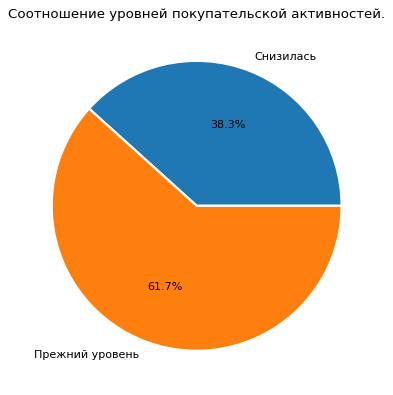

In [34]:
n1 = market_file[market_file['Покупательская_активность'] == 'Снизилась']['id'].count()
n2 = market_file[market_file['Покупательская_активность'] == 'Прежний уровень']['id'].count()
plt.figure(figsize=(10,6), dpi= 80)
plt.pie([n1, n2], labels=['Снизилась', 'Прежний уровень'], wedgeprops = { 'linewidth' : 2, 'edgecolor' : 'white'}, autopct='%.1f%%')
plt.title('Соотношение уровней покупательской активностей.')
plt.show()

Из диаграммы видно, что присутствует дисбаланс целевого признака Покупательская_активность. Следовательно при разбивке данных на тренировочную и тестовую выборки будем использовать  использовать стратификацию по целевому признаку.

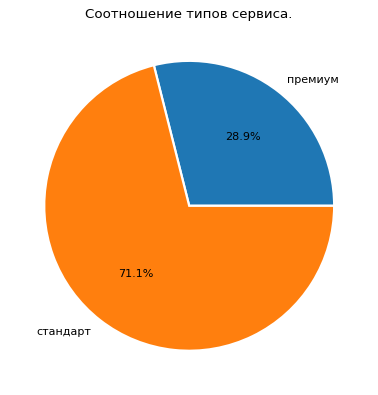

In [35]:
n1 = market_file[market_file['Тип_сервиса'] == 'премиум']['id'].count()
n2 = market_file[market_file['Тип_сервиса'] == 'стандарт']['id'].count()
plt.figure(figsize=(10,6), dpi= 80)
plt.pie([n1, n2], labels=['премиум', 'стандарт'], wedgeprops = { 'linewidth' : 2, 'edgecolor' : 'white'}, autopct='%.1f%%')
plt.title('Соотношение типов сервиса.')
plt.show()

Более распространен тип сервиса стандарт - он составляет 71.1%.

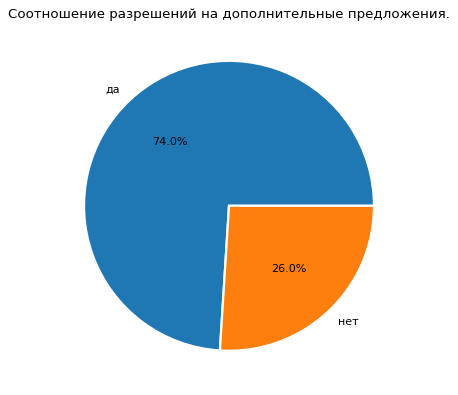

In [36]:
n1 = market_file[market_file['Разрешить_сообщать'] == 'да']['id'].count()
n2 = market_file[market_file['Разрешить_сообщать'] == 'нет']['id'].count()
plt.figure(figsize=(10,6), dpi= 80)
plt.pie([n1, n2], labels=['да', 'нет'], wedgeprops = { 'linewidth' : 2, 'edgecolor' : 'white'}, autopct='%.1f%%')
plt.title('Соотношение разрешений на дополнительные предложения.')
plt.show()

Большинство клиентов - 74% согласно на получение дополнительных предложений.

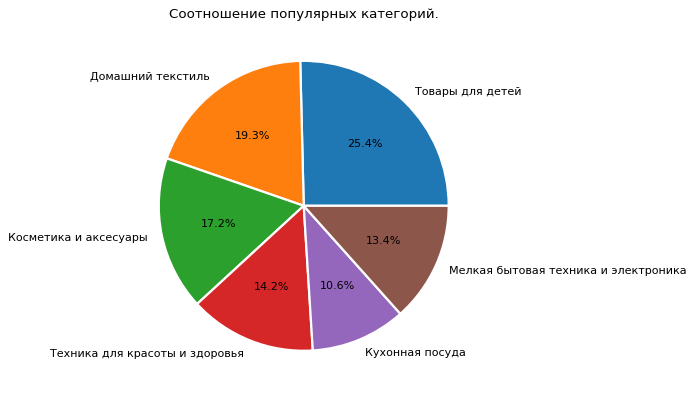

In [37]:
n1 = market_file[market_file['Популярная_категория'] == 'Товары для детей']['id'].count()
n2 = market_file[market_file['Популярная_категория'] == 'Домашний текстиль']['id'].count()
n3 = market_file[market_file['Популярная_категория'] == 'Косметика и аксесуары']['id'].count()
n4 = market_file[market_file['Популярная_категория'] == 'Техника для красоты и здоровья']['id'].count()
n5 = market_file[market_file['Популярная_категория'] == 'Кухонная посуда']['id'].count()
n6 = market_file[market_file['Популярная_категория'] == 'Мелкая бытовая техника и электроника']['id'].count()
plt.figure(figsize=(10,6), dpi= 80)
plt.pie([n1, n2, n3, n4, n5, n6], labels=['Товары для детей', 'Домашний текстиль', 'Косметика и аксесуары','Техника для красоты и здоровья', 'Кухонная посуда', 'Мелкая бытовая техника и электроника'], wedgeprops = { 'linewidth' : 2, 'edgecolor' : 'white'}, autopct='%.1f%%')
plt.title('Соотношение популярных категорий.')
plt.show()

Самую большую долю занимают товары для детей, самую маленькую - кухонная посуда. Вдальнейшем будем анализировать сегмент покупателей,  которые покупают только технику, то есть товары с длинным жизненным циклом. Доля этой категории составляет 13,4+14,2 = 27,6% - практически треть от всех категорий.

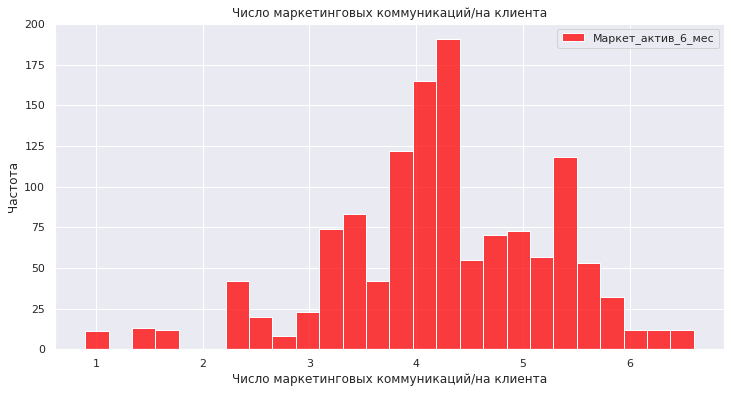

In [38]:
plt.figure(figsize=(12,6))
sns.set_theme(style="darkgrid")

sns.histplot(data=market_file, x="Маркет_актив_6_мес", color="red", label="Маркет_актив_6_мес")

plt.ylabel('Частота')
plt.xlabel('Число маркетинговых коммуникаций/на клиента')
plt.title('Число маркетинговых коммуникаций/на клиента')
plt.legend() 
plt.show()

Признак Число маркетинговых коммуникаций/на клиента распределен неравномерно.

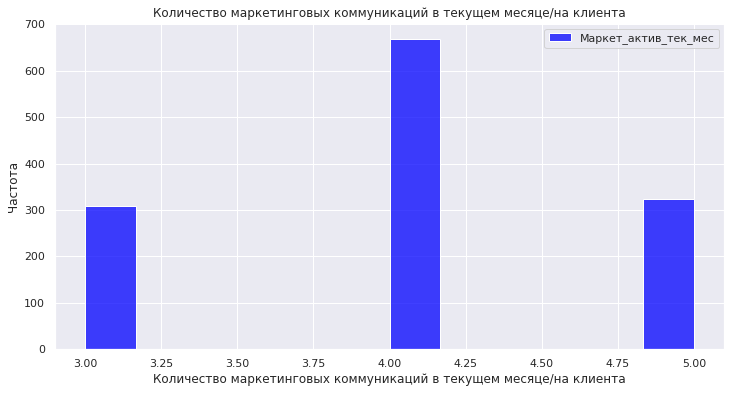

In [39]:
plt.figure(figsize=(12,6))
sns.set_theme(style="darkgrid")

sns.histplot(data=market_file, x="Маркет_актив_тек_мес", color="blue", label="Маркет_актив_тек_мес")

plt.ylabel('Частота')
plt.xlabel('Количество маркетинговых коммуникаций в текущем месяце/на клиента')
plt.title('Количество маркетинговых коммуникаций в текущем месяце/на клиента')
plt.legend() 
plt.show()

Признак Количество маркетинговых коммуникаций в текущем месяце/на клиента принимает дискретные значения.

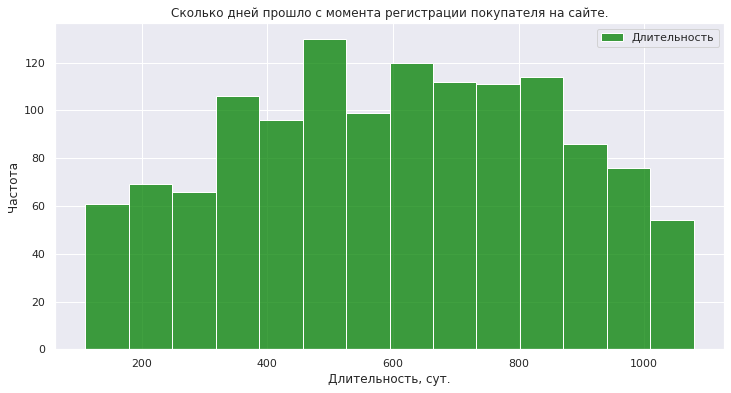

In [40]:
plt.figure(figsize=(12,6))
sns.set_theme(style="darkgrid")

sns.histplot(data=market_file, x="Длительность", color="green", label="Длительность")

plt.ylabel('Частота')
plt.xlabel('Длительность, сут.')
plt.title('Сколько дней прошло с момента регистрации покупателя на сайте.')
plt.legend() 
plt.show()

Распределение признака Длительность непрерывное, достаточно симметричное.

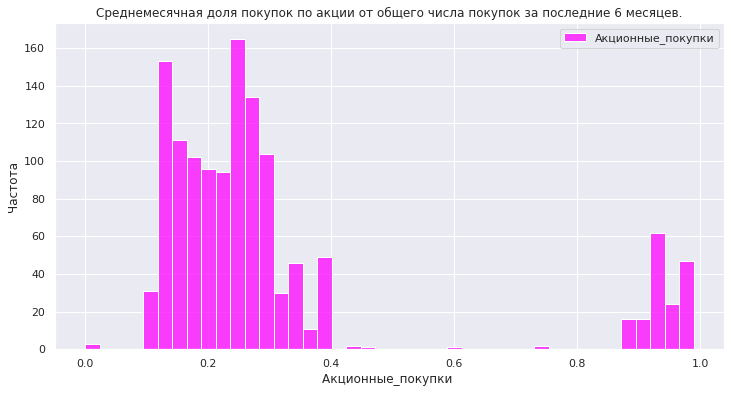

In [41]:
plt.figure(figsize=(12,6))
sns.set_theme(style="darkgrid")

sns.histplot(data=market_file, x="Акционные_покупки", color="magenta", label="Акционные_покупки")

plt.ylabel('Частота')
plt.xlabel('Акционные_покупки ')
plt.title('Cреднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.')
plt.legend() 
plt.show()

Распределение признака Акционные_покупки носит бимодальный характер. Есть группа клиентов, которые покупают товары только по акции.

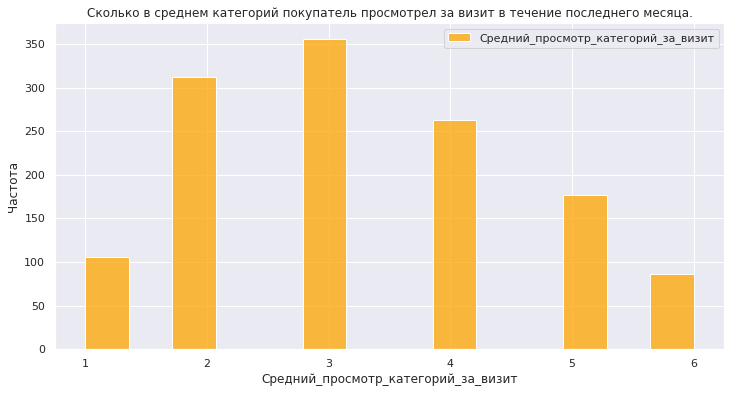

In [42]:
plt.figure(figsize=(12,6))
sns.set_theme(style="darkgrid")

sns.histplot(data=market_file, x="Средний_просмотр_категорий_за_визит", color="orange", label="Средний_просмотр_категорий_за_визит")

plt.ylabel('Частота')
plt.xlabel('Средний_просмотр_категорий_за_визит')
plt.title('Cколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.')
plt.legend() 
plt.show()

Признак Средний_просмотр_категорий_за_визит принимает дискретные значения. Чаще всего за визит просматривается 3 категории.

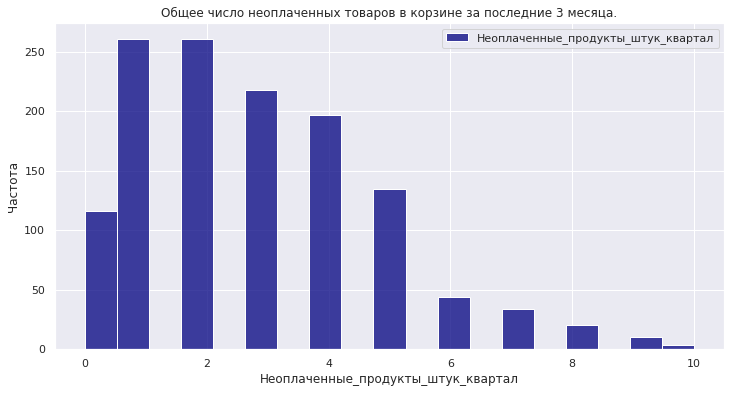

In [43]:
plt.figure(figsize=(12,6))
sns.set_theme(style="darkgrid")

sns.histplot(data=market_file, x="Неоплаченные_продукты_штук_квартал", color="navy", label="Неоплаченные_продукты_штук_квартал")

plt.ylabel('Частота')
plt.xlabel('Неоплаченные_продукты_штук_квартал')
plt.title('Общее число неоплаченных товаров в корзине за последние 3 месяца.')
plt.legend() 
plt.show()

Признак Неоплаченные_продукты_штук_квартал принимает дискретные значения, распределение несимметричное, смещено влево. Обычно в корзине 1-2 неоплаченных товара.

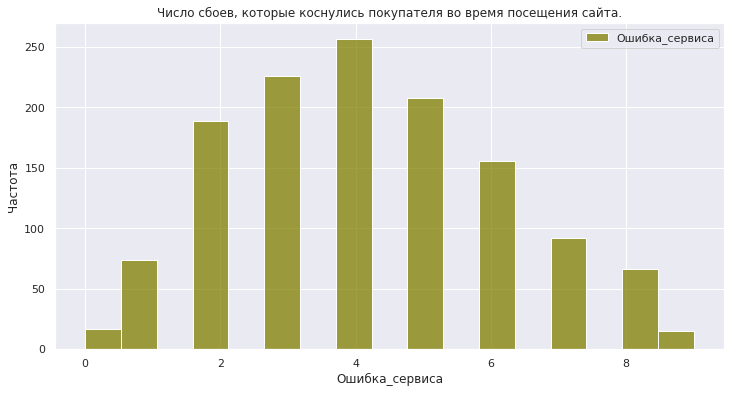

In [44]:
plt.figure(figsize=(12,6))
sns.set_theme(style="darkgrid")

sns.histplot(data=market_file, x="Ошибка_сервиса", color="olive", label="Ошибка_сервиса")

plt.ylabel('Частота')
plt.xlabel('Ошибка_сервиса')
plt.title('Число сбоев, которые коснулись покупателя во время посещения сайта.')
plt.legend() 
plt.show()

Признак Ошибка_сервиса принимает дискретные значения, распределение достаточно симметричное с максимумом - 4 сбоя.

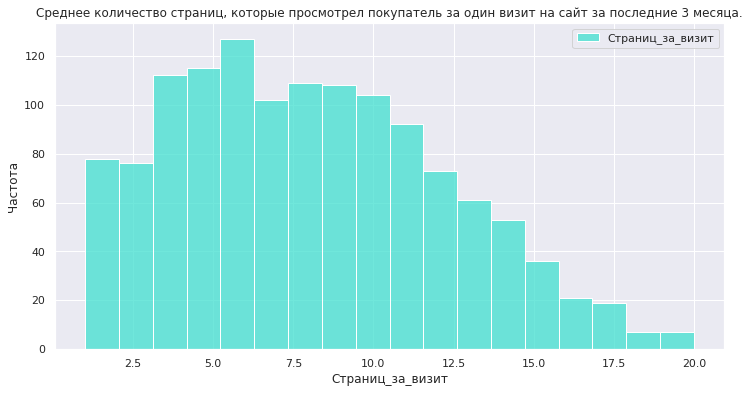

In [45]:
plt.figure(figsize=(12,6))
sns.set_theme(style="darkgrid")

sns.histplot(data=market_file, x="Страниц_за_визит", color="turquoise", label="Страниц_за_визит")

plt.ylabel('Частота')
plt.xlabel('Страниц_за_визит')
plt.title('Среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.')
plt.legend() 
plt.show()

Распределение признака Страниц_за_визит непрерывное, несимметричное, смещено влево. Чаще всего покупатель просматривает 5 страниц за один визит на сайт за последние 3 месяца.

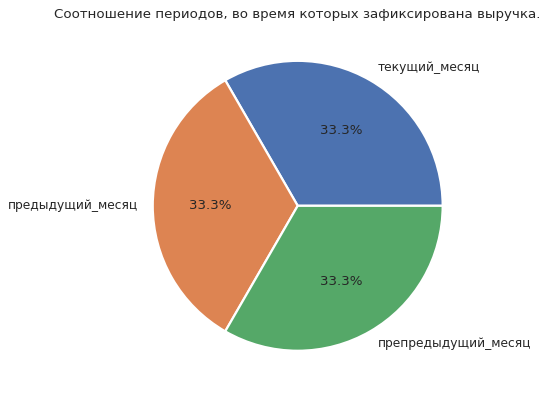

In [46]:
n1 = market_money[market_money['Период'] == 'текущий_месяц']['id'].count()
n2 = market_money[market_money['Период'] == 'предыдущий_месяц']['id'].count()
n3 = market_money[market_money['Период'] == 'препредыдущий_месяц']['id'].count()
plt.figure(figsize=(10,6), dpi= 80)
plt.pie([n1, n2, n3], labels=['текущий_месяц', 'предыдущий_месяц', 'препредыдущий_месяц'], wedgeprops = { 'linewidth' : 2, 'edgecolor' : 'white'}, autopct='%.1f%%')
plt.title('Соотношение периодов, во время которых зафиксирована выручка.')
plt.show()

<font color='magenta'>Соотношение всех трех периодов, во время которых зафиксирована выручка - 1:1:1.</font>

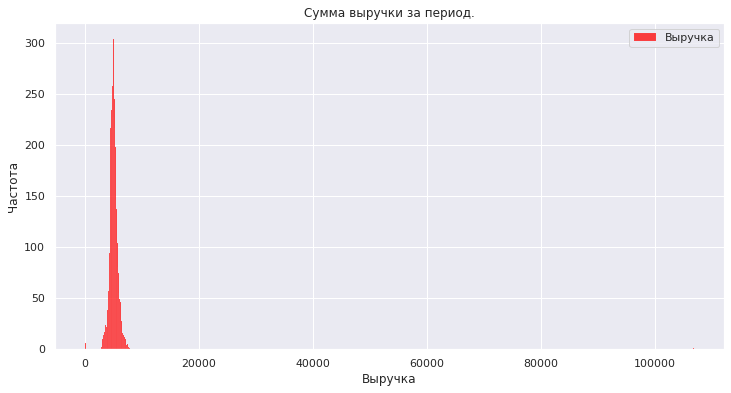

In [47]:
plt.figure(figsize=(12,6))
sns.set_theme(style="darkgrid")

sns.histplot(data=market_money, x="Выручка", color="red", label="Выручка")

plt.ylabel('Частота')
plt.xlabel('Выручка')
plt.title('Сумма выручки за период.')
plt.legend() 
plt.show()

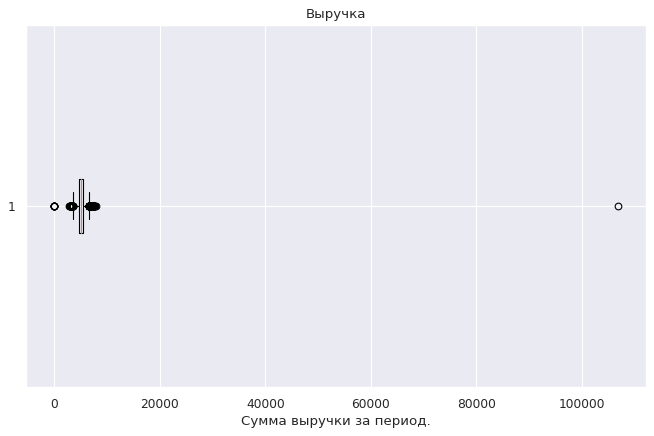

In [48]:
plt.figure(figsize=(10,6), dpi= 80)
plt.boxplot(market_money['Выручка'], vert=False)
plt.title('Выручка')
plt.xlabel('Сумма выручки за период.')
plt.show()

Видно, что для признака Выручка наблюдается аномальный выброс, соответствующий значению больше 20 тыс. . Строку, соответствующую этому выбросу необходимо удалить из датафрейма.

In [49]:
market_money.loc[market_money['Выручка'] > 20000]

id         Период   Выручка
98  215380  текущий_месяц  106862.2

In [50]:
market_money = market_money.loc[market_money['Выручка'] < 20000].reset_index(drop= True)

In [51]:
market_money.query('id == 215380')

id               Период  Выручка
96  215380  препредыдущий_месяц   5051.0
97  215380     предыдущий_месяц   6077.0

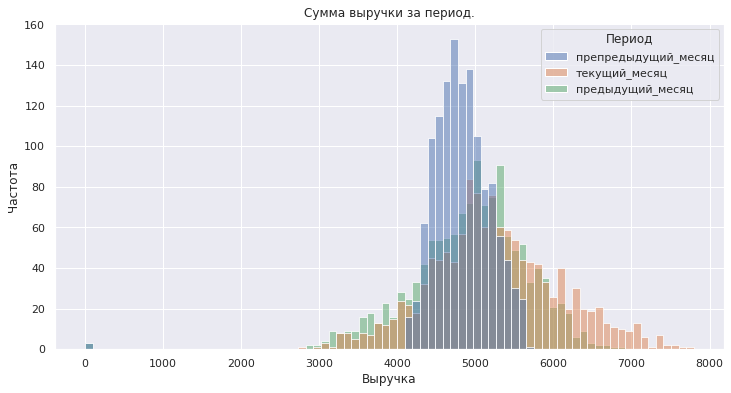

In [52]:
plt.figure(figsize=(12,6))
sns.set_theme(style="darkgrid")

sns.histplot(data=market_money, x="Выручка", color="green",  hue="Период")

plt.ylabel('Частота')
plt.xlabel('Выручка')
plt.title('Сумма выручки за период.')
#plt.legend() 
plt.show()

In [53]:
market_money.loc[market_money['Выручка'] < 1000]

id               Период  Выручка
0   215348  препредыдущий_месяц      0.0
2   215348     предыдущий_месяц      0.0
28  215357  препредыдущий_месяц      0.0
29  215357     предыдущий_месяц      0.0
34  215359     предыдущий_месяц      0.0
35  215359  препредыдущий_месяц      0.0

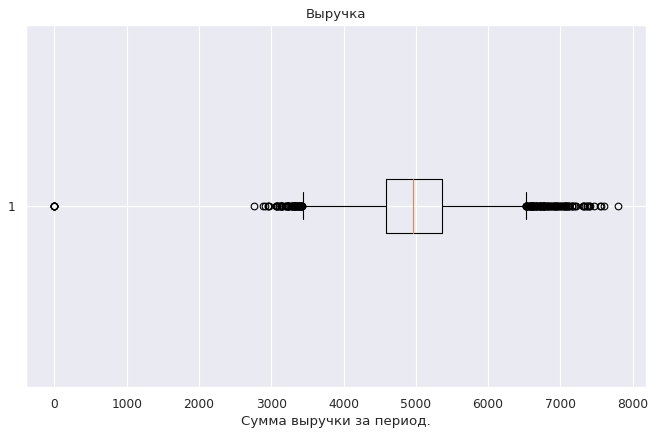

In [54]:
plt.figure(figsize=(10,6), dpi= 80)
plt.boxplot(market_money['Выручка'], vert=False)
plt.title('Выручка')
plt.xlabel('Сумма выручки за период.')
plt.show()

In [55]:
print('Среднее значение параметра Выручка:', round(market_money['Выручка'].mean(), 2))

Среднее значение параметра Выручка: 4999.58


In [56]:
print('Медианное значение параметра Выручка:', round(market_money['Выручка'].median(), 2))

Медианное значение параметра Выручка: 4957.0


Теперь выбросов нет. Распределение параметра Выручка является достаточно симметричным относительно центра. Среднее и медианное значения практически совпадают. Среднее значение равно 4999.6 руб. Из распределения параметра видно, что есть небольшое количество покупателей с нулевой выручкой за рассматриваемый период.

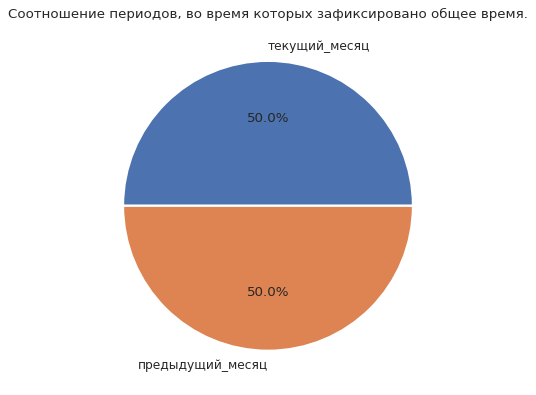

In [57]:
n1 = market_time[market_time['Период'] == 'текущий_месяц']['id'].count()
n2 = market_time[market_time['Период'] == 'предыдущий_месяц']['id'].count()
plt.figure(figsize=(10,6), dpi= 80)
plt.pie([n1, n2], labels=['текущий_месяц', 'предыдущий_месяц'], wedgeprops = { 'linewidth' : 2, 'edgecolor' : 'white'}, autopct='%.1f%%')
plt.title('Соотношение периодов, во время которых зафиксировано общее время.')
plt.show()

Соотношение периодов, во время которых зафиксировано общее время: 1:1.

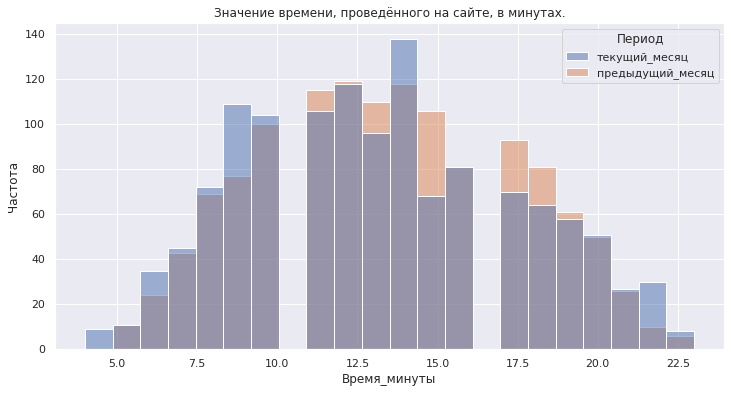

In [58]:
plt.figure(figsize=(12,6))
sns.set_theme(style="darkgrid")

sns.histplot(data=market_time, x="Время_минуты", color="blue", hue="Период")

plt.ylabel('Частота')
plt.xlabel('Время_минуты')
plt.title('Значение времени, проведённого на сайте, в минутах.')
#plt.legend() 
plt.show()

Значение признака - времени, проведённого на сайте, в минутах, распалось на три группы. Чаще всего время находится в диапазоне 11-16 минут.

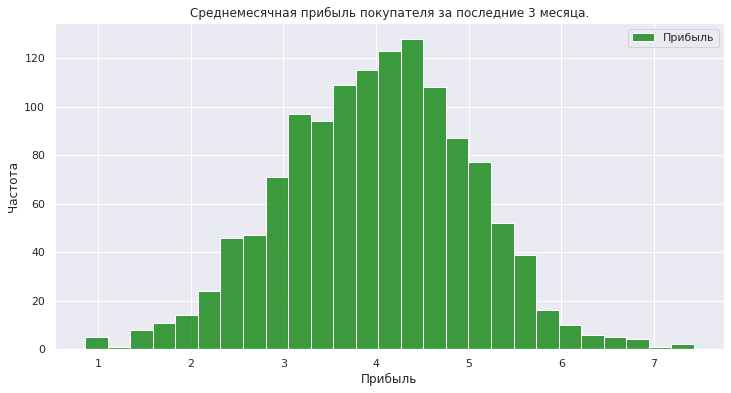

In [59]:
plt.figure(figsize=(12,6))
sns.set_theme(style="darkgrid")

sns.histplot(data=money, x="Прибыль", color="green", label="Прибыль")

plt.ylabel('Частота')
plt.xlabel('Прибыль')
plt.title('Среднемесячная прибыль покупателя за последние 3 месяца.')
plt.legend() 
plt.show()

In [60]:
print('Среднее значение параметра Прибыль:', round(money['Прибыль'].mean(), 2))

Среднее значение параметра Прибыль: 4.0


In [61]:
print('Медианное значение параметра Прибыль:', round(money['Прибыль'].median(), 2))

Медианное значение параметра Прибыль: 4.04


Распределение параметра Прибыль является достаточно симметричным относительно центра. Среднее и медианное значения практически совпадают. Среднее значение равно 4.0 тыс.руб.

Сделаем так, чтобы выручка и прибыль измерялись в одинаковых единицах - рублях. Для этого умножим все значения в колонке Прибыль на 1000.

In [62]:
money['Прибыль'] = money['Прибыль']*1000

In [63]:
print('Среднее значение параметра Прибыль:', round(money['Прибыль'].mean(), 2))

Среднее значение параметра Прибыль: 3996.63


In [64]:
print('Медианное значение параметра Прибыль:', round(money['Прибыль'].median(), 2))

Медианное значение параметра Прибыль: 4045.0


In [65]:
display(market_file)

id Покупательская_активность Тип_сервиса Разрешить_сообщать  \
0     215348                 Снизилась     премиум                 да   
1     215349                 Снизилась     премиум                 да   
2     215350                 Снизилась    стандарт                нет   
3     215351                 Снизилась    стандарт                 да   
4     215352                 Снизилась    стандарт                нет   
...      ...                       ...         ...                ...   
1295  216643           Прежний уровень    стандарт                 да   
1296  216644           Прежний уровень    стандарт                нет   
1297  216645           Прежний уровень    стандарт                 да   
1298  216646           Прежний уровень    стандарт                 да   
1299  216647           Прежний уровень     премиум                 да   

      Маркет_актив_6_мес  Маркет_актив_тек_мес  Длительность  \
0                    3.4                     5           121   
1                    4.4                     4           819   
2                    4.9                     3           539   
3                    3.2                     5           896   
4                    5.1                     3          1064   
...                  ...                   ...           ...   
1295                 6.6                     3           318   
1296                 5.1                     4           454   
1297                 4.1                     3           586   
1298                 6.3                     5           645   
1299                 4.0                     5           906   

      Акционные_покупки            Популярная_категория  \
0                  0.00                Товары для детей   
1                  0.75                Товары для детей   
2                  0.14               Домашний текстиль   
3                  0.99                Товары для детей   
4                  0.94                Товары для детей   
...                 ...                             ...   
1295               0.24  Техника для красоты и здоровья   
1296               0.21               Домашний текстиль   
1297               0.20               Домашний текстиль   
1298               0.12  Техника для красоты и здоровья   
1299               0.94  Техника для красоты и здоровья   

      Средний_просмотр_категорий_за_визит  Неоплаченные_продукты_штук_квартал  \
0                                       6                                   2   
1                                       4                                   4   
2                                       5                                   2   
3                                       5                                   0   
4                                       3                                   2   
...                                   ...                                 ...   
1295                                    5                                   3   
1296                                    6                                   2   
1297                                    3                                   2   
1298                                    3                                   3   
1299                                    4                                   5   

      Ошибка_сервиса  Страниц_за_визит  
0                  1                 5  
1                  2                 5  
2                  1                 5  
3                  6                 4  
4                  3                 2  
...              ...               ...  
1295               3                11  
1296               3                 9  
1297               5                 7  
1298               5                 7  
1299               3                12  

[1300 rows x 13 columns]

In [66]:
display(money)

id  Прибыль
0     215348    980.0
1     215349   4160.0
2     215350   3130.0
3     215351   4870.0
4     215352   4210.0
...      ...      ...
1295  216643   4440.0
1296  216644   6110.0
1297  216645   3290.0
1298  216646   4030.0
1299  216647   3280.0

[1300 rows x 2 columns]

<font color='magenta'>Отберем клиентов с покупательской активностью не менее трёх месяцев, то есть пользователей без покупок хотя бы в одном из трёх месяцев.</font>

In [67]:
market_money.head()

id               Период  Выручка
0  215348  препредыдущий_месяц      0.0
1  215348        текущий_месяц   3293.1
2  215348     предыдущий_месяц      0.0
3  215349  препредыдущий_месяц   4472.0
4  215349        текущий_месяц   4971.6

In [68]:
id_list = market_money[market_money['Выручка'] == 0]['id']

In [69]:
display(id_list)

0     215348
2     215348
28    215357
29    215357
34    215359
35    215359
Name: id, dtype: int64

In [70]:
market_file_3_month = market_file.query('id not in @id_list')

In [71]:
market_file_3_month = market_file_3_month.query('id != 215380').reset_index(drop=True)

In [72]:
display(market_file_3_month)

id Покупательская_активность Тип_сервиса Разрешить_сообщать  \
0     215349                 Снизилась     премиум                 да   
1     215350                 Снизилась    стандарт                нет   
2     215351                 Снизилась    стандарт                 да   
3     215352                 Снизилась    стандарт                нет   
4     215353                 Снизилась    стандарт                 да   
...      ...                       ...         ...                ...   
1291  216643           Прежний уровень    стандарт                 да   
1292  216644           Прежний уровень    стандарт                нет   
1293  216645           Прежний уровень    стандарт                 да   
1294  216646           Прежний уровень    стандарт                 да   
1295  216647           Прежний уровень     премиум                 да   

      Маркет_актив_6_мес  Маркет_актив_тек_мес  Длительность  \
0                    4.4                     4           819   
1                    4.9                     3           539   
2                    3.2                     5           896   
3                    5.1                     3          1064   
4                    3.3                     4           762   
...                  ...                   ...           ...   
1291                 6.6                     3           318   
1292                 5.1                     4           454   
1293                 4.1                     3           586   
1294                 6.3                     5           645   
1295                 4.0                     5           906   

      Акционные_покупки            Популярная_категория  \
0                  0.75                Товары для детей   
1                  0.14               Домашний текстиль   
2                  0.99                Товары для детей   
3                  0.94                Товары для детей   
4                  0.26               Домашний текстиль   
...                 ...                             ...   
1291               0.24  Техника для красоты и здоровья   
1292               0.21               Домашний текстиль   
1293               0.20               Домашний текстиль   
1294               0.12  Техника для красоты и здоровья   
1295               0.94  Техника для красоты и здоровья   

      Средний_просмотр_категорий_за_визит  Неоплаченные_продукты_штук_квартал  \
0                                       4                                   4   
1                                       5                                   2   
2                                       5                                   0   
3                                       3                                   2   
4                                       4                                   1   
...                                   ...                                 ...   
1291                                    5                                   3   
1292                                    6                                   2   
1293                                    3                                   2   
1294                                    3                                   3   
1295                                    4                                   5   

      Ошибка_сервиса  Страниц_за_визит  
0                  2                 5  
1                  1                 5  
2                  6                 4  
3                  3                 2  
4                  1                 4  
...              ...               ...  
1291               3                11  
1292               3                 9  
1293               5                 7  
1294               5                 7  
1295               3                12  

[1296 rows x 13 columns]

Исследовательский анализ данных показал следующее:
Из диаграммы видно, что присутствует дисбаланс целевого признака Покупательская_активность. Следовательно при разбивке данных на тренировочную и тестовую выборки будем использовать использовать стратификацию по целевому признаку.
Более распространен тип сервиса стандарт - он составляет 71.1%.
Большинство клиентов - 74% согласно на получение дополнительных предложений.
Самую большую долю занимают товары для детей, самую маленькую - кухонная посуда. Вдальнейшем будем анализировать сегмент покупателей, которые покупают только технику, то есть товары с длинным жизненным циклом. Доля этой категории составляет 13,4+14,2 = 27,6% - практически треть от всех категорий.
Признак Число маркетинговых коммуникаций/на клиента распределен неравномерно.
Признак Количество маркетинговых коммуникаций в текущем месяце/на клиента принимает дискретные значения.
Распределение признака Длительность непрерывное, достаточно симметричное
Распределение признака Акционные_покупки носит бимодальный характер. Есть группа клиентов, которые покупают товары только по акции.
Признак Средний_просмотр_категорий_за_визит принимает дискретные значения. Чаще всего за визит просматривается 3 категории.
Признак Неоплаченные_продукты_штук_квартал принимает дискретные значения, распределение несимметричное, смещено влево. Обычно в корзине 1-2 неоплаченных товара.
Признак Ошибка_сервиса принимает дискретные значения, распределение достаточно симметричное с максимумом - 4 сбоя.
Распределение признака Страниц_за_визит непрерывное, несимметричное, смещено влево. Чаще всего покупатель просматривает 5 страниц за один визит на сайт за последние 3 месяца.
Соотношение всех трех периодов, во время которых зафиксирована выручка - 1:1:1.
Удален выброс параметра Выручка. Распределение параметра Выручка является достаточно симметричным относительно центра. Среднее и медианное значения практически совпадают. Среднее значение равно 4999.6 руб. Из распределения параметра видно, что есть небольшое количество покупателей с нулевой выручкой за рассматриваемый период.
Соотношение периодов, во время которых зафиксировано общее время: 1:1.
Значение признака - времени, проведённого на сайте, в минутах, распалось на три группы. Чаще всего время находится в диапазоне 11-16 минут.
Распределение параметра Прибыль является достаточно симметричным относительно центра. Среднее и медианное значения практически совпадают. Среднее значение равно 4.0 тыс.руб.

### Шаг 4. Объединение таблиц

<font color='magenta'>Объединим датафреймы market_file, market_money и market_time. Перед объединением удалим строки с id, для которых был выбос выручки и строки, соответствующие пользователям без покупок хотя бы в одном из трёх месяцев.</font>

In [73]:
market_time = market_time.query('id != 215380').reset_index(drop=True)

In [74]:
market_time = market_time.query('id not in @id_list').reset_index(drop=True)

In [75]:
market_time.head()

id            Период  Время_минуты
0  215349     текущий_месяц            10
1  215349  предыдущий_месяц            12
2  215350     текущий_месяц            13
3  215350  предыдущий_месяц             8
4  215351     текущий_месяц            13

In [76]:
market_time1 = pd.pivot_table(market_time,
               index=["id"],
               columns=["Период"])

In [77]:
market_time1

Время_минуты              
Период предыдущий_месяц текущий_месяц
id                                   
215349               12            10
215350                8            13
215351               11            13
215352                8            11
215353               10            10
...                 ...           ...
216643               14             7
216644               12            11
216645               12            18
216646               18             7
216647               15            10

[1296 rows x 2 columns]

In [78]:
market_time1.columns = ['Время_пред', 'Время_тек']

In [79]:
market_time1

Время_пред  Время_тек
id                           
215349          12         10
215350           8         13
215351          11         13
215352           8         11
215353          10         10
...            ...        ...
216643          14          7
216644          12         11
216645          12         18
216646          18          7
216647          15         10

[1296 rows x 2 columns]

In [80]:
market_money = market_money.query('id != 215380').reset_index(drop=True)

In [81]:
market_money = market_money.query('id not in @id_list').reset_index(drop=True)

In [82]:
market_money1 = pd.pivot_table(market_money,
               index=["id"],
               columns=["Период"])

In [83]:
market_money1

Выручка                                  
Период предыдущий_месяц препредыдущий_месяц текущий_месяц
id                                                       
215349           5216.0              4472.0        4971.6
215350           5457.5              4826.0        5058.4
215351           6158.0              4793.0        6610.4
215352           5807.5              4594.0        5872.5
215353           4738.5              5124.0        5388.5
...                 ...                 ...           ...
216643           3664.0              4704.0        4741.7
216644           4729.0              5299.0        5353.0
216645           5160.0              5334.0        5139.2
216646           4923.0              4725.0        5224.6
216647           4720.0              5183.0        4448.3

[1296 rows x 3 columns]

In [84]:
market_money1.columns = ['Выручка_1', 'Выручка_2', 'Выручка_3']

In [85]:
market_money1

Выручка_1  Выручка_2  Выручка_3
id                                     
215349     5216.0     4472.0     4971.6
215350     5457.5     4826.0     5058.4
215351     6158.0     4793.0     6610.4
215352     5807.5     4594.0     5872.5
215353     4738.5     5124.0     5388.5
...           ...        ...        ...
216643     3664.0     4704.0     4741.7
216644     4729.0     5299.0     5353.0
216645     5160.0     5334.0     5139.2
216646     4923.0     4725.0     5224.6
216647     4720.0     5183.0     4448.3

[1296 rows x 3 columns]

In [86]:
data_full = market_file_3_month.merge(market_money1, on='id').merge(market_time1, on='id')

In [87]:
display(data_full)

id Покупательская_активность Тип_сервиса Разрешить_сообщать  \
0     215349                 Снизилась     премиум                 да   
1     215350                 Снизилась    стандарт                нет   
2     215351                 Снизилась    стандарт                 да   
3     215352                 Снизилась    стандарт                нет   
4     215353                 Снизилась    стандарт                 да   
...      ...                       ...         ...                ...   
1291  216643           Прежний уровень    стандарт                 да   
1292  216644           Прежний уровень    стандарт                нет   
1293  216645           Прежний уровень    стандарт                 да   
1294  216646           Прежний уровень    стандарт                 да   
1295  216647           Прежний уровень     премиум                 да   

      Маркет_актив_6_мес  Маркет_актив_тек_мес  Длительность  \
0                    4.4                     4           819   
1                    4.9                     3           539   
2                    3.2                     5           896   
3                    5.1                     3          1064   
4                    3.3                     4           762   
...                  ...                   ...           ...   
1291                 6.6                     3           318   
1292                 5.1                     4           454   
1293                 4.1                     3           586   
1294                 6.3                     5           645   
1295                 4.0                     5           906   

      Акционные_покупки            Популярная_категория  \
0                  0.75                Товары для детей   
1                  0.14               Домашний текстиль   
2                  0.99                Товары для детей   
3                  0.94                Товары для детей   
4                  0.26               Домашний текстиль   
...                 ...                             ...   
1291               0.24  Техника для красоты и здоровья   
1292               0.21               Домашний текстиль   
1293               0.20               Домашний текстиль   
1294               0.12  Техника для красоты и здоровья   
1295               0.94  Техника для красоты и здоровья   

      Средний_просмотр_категорий_за_визит  Неоплаченные_продукты_штук_квартал  \
0                                       4                                   4   
1                                       5                                   2   
2                                       5                                   0   
3                                       3                                   2   
4                                       4                                   1   
...                                   ...                                 ...   
1291                                    5                                   3   
1292                                    6                                   2   
1293                                    3                                   2   
1294                                    3                                   3   
1295                                    4                                   5   

      Ошибка_сервиса  Страниц_за_визит  Выручка_1  Выручка_2  Выручка_3  \
0                  2                 5     5216.0     4472.0     4971.6   
1                  1                 5     5457.5     4826.0     5058.4   
2                  6                 4     6158.0     4793.0     6610.4   
3                  3                 2     5807.5     4594.0     5872.5   
4                  1                 4     4738.5     5124.0     5388.5   
...              ...               ...        ...        ...        ...   
1291               3                11     3664.0     4704.0     4741.7   
1292               3                 9     4729.0     5299.0     5353.0   
1293   

In [88]:
num_col = ['Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность', 'Акционные_покупки',
           'Средний_просмотр_категорий_за_визит', 'Неоплаченные_продукты_штук_квартал',
           'Ошибка_сервиса', 'Страниц_за_визит', 'Время_пред', 'Время_тек', 'Выручка_1', 'Выручка_2', 'Выручка_3']
cat_col = ['Разрешить_сообщать', 'Популярная_категория']
ord_col = ['Тип_сервиса']

### Шаг 5. Корреляционный анализ

Для установления корреляций между целевым параметром Покупательская_активность и остальными признаками воспользуемся корреляцией Phi_K. Построим матрицу корреляций Phi_K.

In [89]:
data = data_full.drop('id', axis=1)

In [90]:
data_phik = data.phik_matrix(interval_cols = num_col)
display(data_phik)

Покупательская_активность  Тип_сервиса  \
Покупательская_активность                             1.000000     0.129940   
Тип_сервиса                                           0.129940     1.000000   
Разрешить_сообщать                                    0.000000     0.289965   
Маркет_актив_6_мес                                    0.544831     0.089911   
Маркет_актив_тек_мес                                  0.000000     0.045258   
Длительность                                          0.099901     0.401411   
Акционные_покупки                                     0.506276     0.030010   
Популярная_категория                                  0.299717     0.070809   
Средний_просмотр_категорий_за_визит                   0.539607     0.185391   
Неоплаченные_продукты_штук_квартал                    0.505655     0.120027   
Ошибка_сервиса                                        0.224154     0.079515   
Страниц_за_визит                                      0.749888     0.102594   
Выручка_1                                             0.224638     0.000000   
Выручка_2                                             0.497393     0.069704   
Выручка_3                                             0.197213     0.124216   
Время_пред                                            0.685138     0.131814   
Время_тек                                             0.576770     0.000000   

                                     Разрешить_сообщать  Маркет_актив_6_мес  \
Покупательская_активность                      0.000000            0.544831   
Тип_сервиса                                    0.289965            0.089911   
Разрешить_сообщать                             1.000000            0.000000   
Маркет_актив_6_мес                             0.000000            1.000000   
Маркет_актив_тек_мес                           0.052618            0.079854   
Длительность                                   0.253831            0.000000   
Акционные_покупки                              0.012198            0.279553   
Популярная_категория                           0.073684            0.150386   
Средний_просмотр_категорий_за_визит            0.070359            0.206788   
Неоплаченные_продукты_штук_квартал             0.195982            0.289421   
Ошибка_сервиса                                 0.021839            0.142401   
Страниц_за_визит                               0.042134            0.396769   
Выручка_1                                      0.080842            0.155476   
Выручка_2                                      0.000000            0.315331   
Выручка_3                                      0.060907            0.039795   
Время_пред                                     0.038387            0.363950   
Время_тек                                      0.000000            0.330601   

                                     Маркет_актив_тек_мес  Длительность  \
Покупательская_активность                        0.000000      0.099901   
Тип_сервиса                                      0.045258      0.401411   
Разрешить_сообщать                               0.052618      0.253831   
Маркет_актив_6_мес                               0.079854      0.000000   
Маркет_актив_тек_мес                             1.000000      0.174233   
Длительность                                     0.174233      1.000000   
Акционные_покупки                                0.000000      0.000000   
Популярная_категория                             0.136243      0.000000   
Средний_просмотр_категорий_за_визит              0.246633      0.186795   
Неоплаченные_продукты_штук_квартал               0.144203      0.192611   
Ошибка_сервиса                                   0.116946      0.175608   
Страниц_за_визит                                 0.000000      0.122495   
Выручка_1                                        0.051824      0.125572   
Выручка_2                                        0.000000      0.113200   
Выручка_3                                        0.000000      0.1

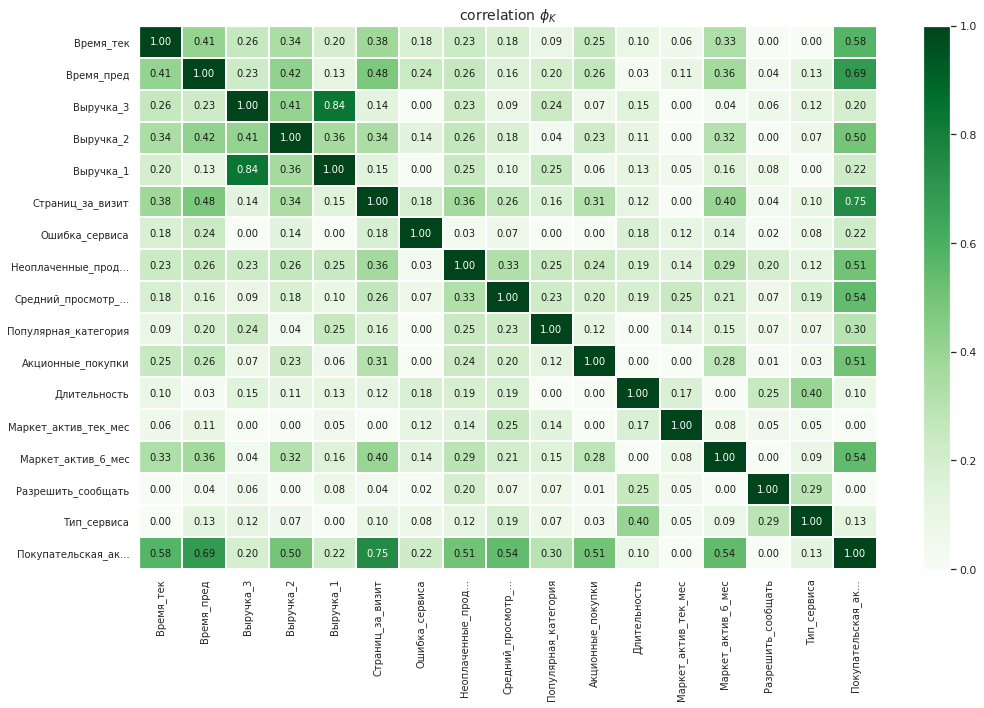

In [91]:
plot_correlation_matrix(data_phik.values, 
                        x_labels=data_phik.columns, 
                        y_labels=data_phik.index,
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1, 
                        figsize=(15, 10))

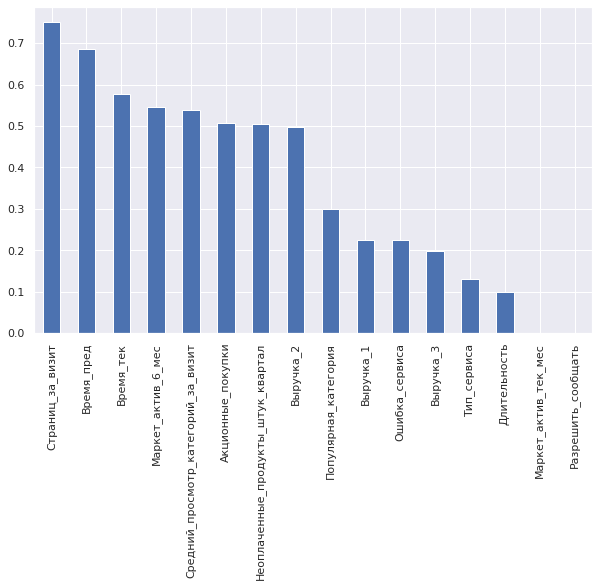

In [92]:
plt.figure(figsize=(10, 6))
_ = data_phik['Покупательская_активность'].sort_values(ascending=False)[1:].plot(kind='bar')

Самая высокая корреляция (коэффициент больше 0.7) между целевым параметром Покупательская_активность и параметром Страниц_за_визит. Коэффициенты от (0.5 до 0.7) - у параметров Время_пред, Время_тек, Маркет_актив_6_мес, Средний_просмотр_категорий_за_визит, Неоплаченные_продукты_штук_квартал и Акционные_покупки. Все коэффициенты  корреляции в матрице меньше 0.9, следовательно мультиколлинеарности не наблюдается.

Построим попарные диаграммы рассеяния. Цветом кодируется целевой признак Покупательская_активность.

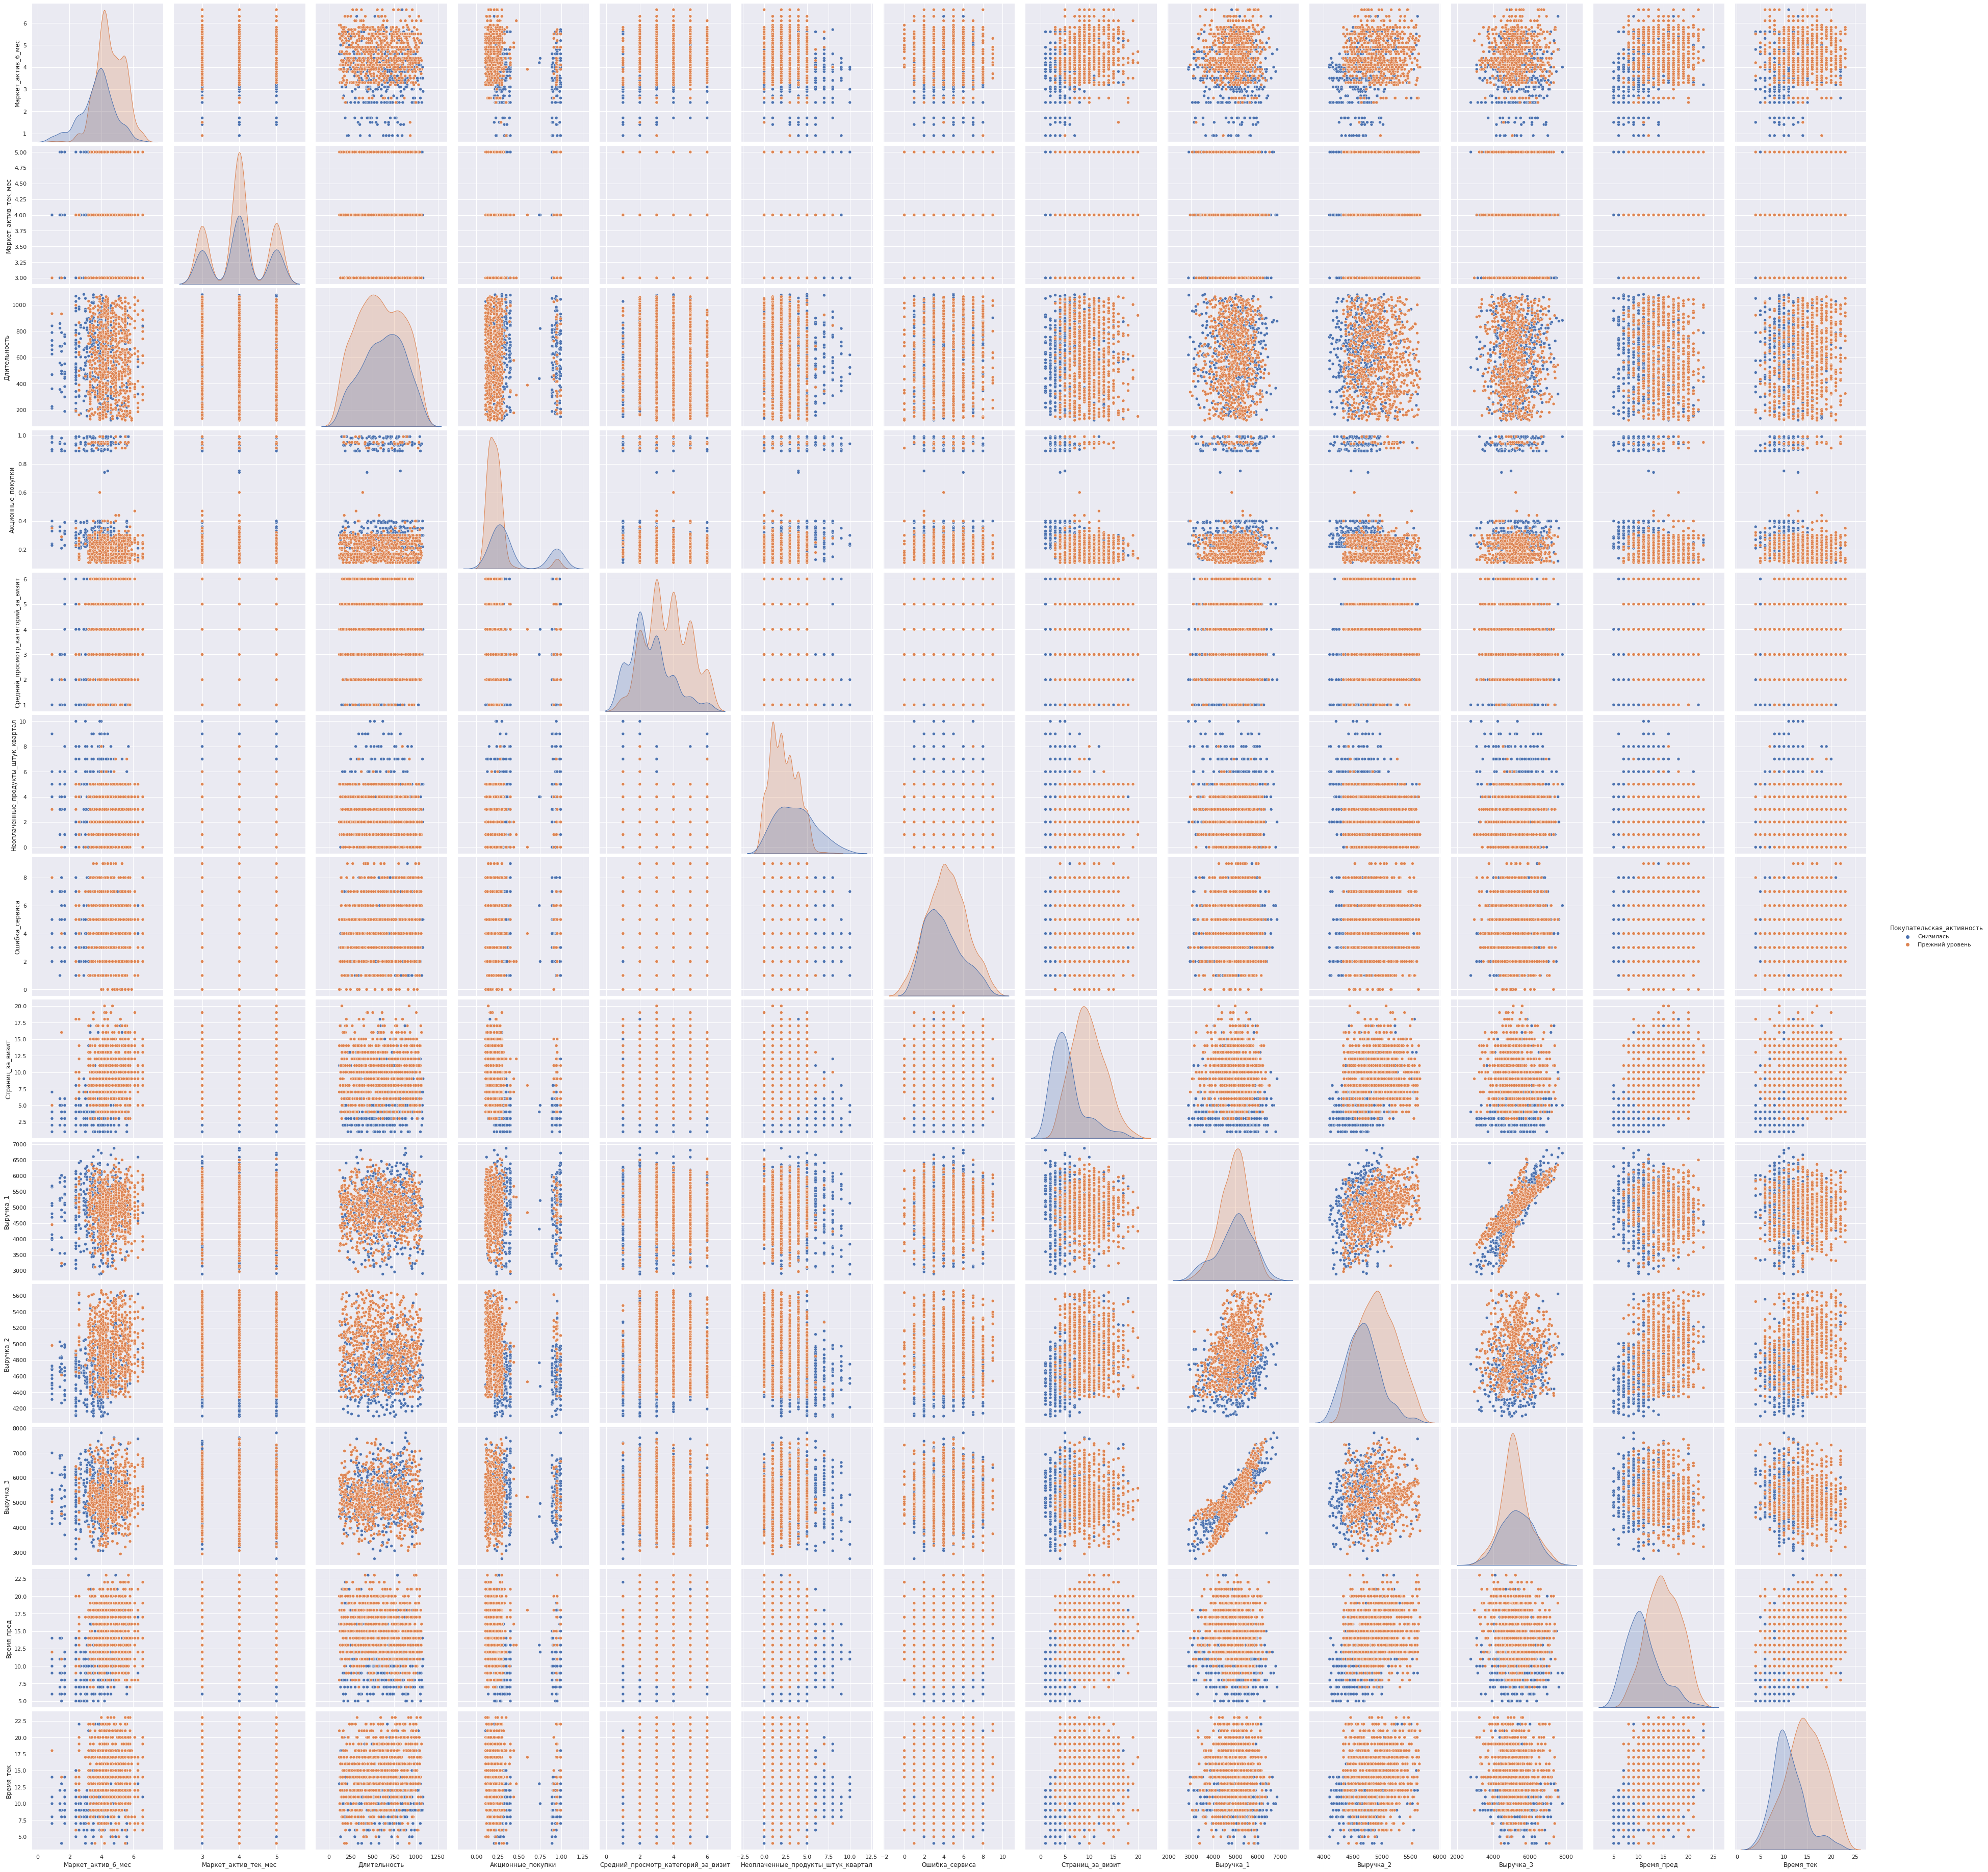

In [93]:
_ = sns.pairplot(data,hue='Покупательская_активность', height=4)

Видно, что на большинстве попарных диаграмм рассеяния точки четко разделяются в зависимости от значения целевого признака.

### Шаг 6. Использование пайплайнов

<font color='magenta'>Закодируем целевой признак при помощи LabelEncoder().</font>
Для подбора гиперпараметров моделей будем использовать рандомизированный (случайный) поиск гиперпараметров с помощью RandomizedSearchCV, который является более быстродействующим по сравнению с GridSearchCV.

In [94]:
encoder = LabelEncoder()
Y = data_full['Покупательская_активность']

In [95]:
X_train, X_test, y_train, y_test = train_test_split(
data_full.drop(
['Покупательская_активность', 'id'],
axis=1
),
Y,
test_size = TEST_SIZE,
random_state = RANDOM_STATE,
stratify = Y
)

In [96]:
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test) 

In [97]:
display(X_train)

Тип_сервиса Разрешить_сообщать  Маркет_актив_6_мес  Маркет_актив_тек_мес  \
506     стандарт                 да                 5.5                     4   
10      стандарт                 да                 5.1                     4   
532     стандарт                 да                 4.3                     5   
1212    стандарт                 да                 5.6                     4   
363      премиум                 да                 3.6                     5   
...          ...                ...                 ...                   ...   
805     стандарт                 да                 4.0                     3   
825     стандарт                 да                 3.5                     4   
583     стандарт                 да                 5.3                     4   
511     стандарт                нет                 4.6                     4   
678     стандарт                 да                 3.3                     4   

      Длительность  Акционные_покупки                  Популярная_категория  \
506            510               0.15  Мелкая бытовая техника и электроника   
10             199               0.23        Техника для красоты и здоровья   
532            997               0.17  Мелкая бытовая техника и электроника   
1212           342               0.94                       Кухонная посуда   
363            873               0.39                      Товары для детей   
...            ...                ...                                   ...   
805            432               0.16                 Косметика и аксесуары   
825            666               0.21  Мелкая бытовая техника и электроника   
583            352               0.13                      Товары для детей   
511            900               0.16  Мелкая бытовая техника и электроника   
678            475               0.26  Мелкая бытовая техника и электроника   

      Средний_просмотр_категорий_за_визит  Неоплаченные_продукты_штук_квартал  \
506                                     2                                   4   
10                                      4                                   5   
532                                     5                                   1   
1212                                    2                                   7   
363                                     3                                   2   
...                                   ...                                 ...   
805                                     4                                   1   
825                                     2                                   2   
583                                     1                                   7   
511                                     5                                   0   
678                                     3                                   1   

      Ошибка_сервиса  Страниц_за_визит  Выручка_1  Выручка_2  Выручка_3  \
506                7                16     5170.5     4347.0     6014.2   
10                 2                 3     6400.0     4597.0     3789.7   
532                3                11     4113.0     4626.0     3798.4   
1212               5                 8     4930.0     5269.0     4766.2   
363                2                 5     3716.0     4691.0     4600.0   
...              ...               ...        ...        ...        ...   
805                2                13     5646.5     4685.0     6609.8   
825                2                 8     4667.0     5132.0     4394.0   
583                3                10     5371.5     5274.0     5586.0   
511                8                 8     4862.0     4985.0     4885.4   
678                5                 7     4914.0     5298.0     4711.2   

      Время_пред  Время_тек  
506           20          6  
10            11         13  
532           13         10  
1212          14         19  
363           10         10  
...          ...        ...  

In [98]:
#y_train

In [99]:
display(X_test)

Тип_сервиса Разрешить_сообщать  Маркет_актив_6_мес  Маркет_актив_тек_мес  \
809    стандарт                 да                 4.1                     4   
302     премиум                нет                 1.4                     4   
955     премиум                 да                 3.3                     4   
149     премиум                 да                 3.5                     3   
582    стандарт                нет                 5.5                     4   
..          ...                ...                 ...                   ...   
77      премиум                нет                 0.9                     4   
881     премиум                 да                 3.9                     4   
364    стандарт                 да                 2.4                     4   
789    стандарт                нет                 4.0                     4   
318    стандарт                 да                 4.1                     4   

     Длительность  Акционные_покупки                  Популярная_категория  \
809           606               0.15        Техника для красоты и здоровья   
302           684               0.94                      Товары для детей   
955           488               0.13                     Домашний текстиль   
149          1057               0.35                     Домашний текстиль   
582           147               0.99  Мелкая бытовая техника и электроника   
..            ...                ...                                   ...   
77            690               0.24                     Домашний текстиль   
881          1048               0.21        Техника для красоты и здоровья   
364           952               0.30        Техника для красоты и здоровья   
789           748               0.28                 Косметика и аксесуары   
318           490               0.98                       Кухонная посуда   

     Средний_просмотр_категорий_за_визит  Неоплаченные_продукты_штук_квартал  \
809                                    6                                   1   
302                                    3                                   6   
955                                    4                                   2   
149                                    4                                   3   
582                                    1                                   2   
..                                   ...                                 ...   
77                                     2                                   5   
881                                    3                                   0   
364                                    3                                   5   
789                                    4                                   0   
318                                    3                                   7   

     Ошибка_сервиса  Страниц_за_визит  Выручка_1  Выручка_2  Выручка_3  \
809               4                12     3973.0     4912.0     3289.2   
302               1                 6     3548.0     4656.0     4170.7   
955               8                10     5444.0     4565.0     6335.8   
149               5                 6     6604.0     4993.0     6758.7   
582               3                 7     5090.0     4451.0     5773.8   
..              ...               ...        ...        ...        ...   
77                7                 4     3662.0     4488.0     4158.6   
881               6                14     4325.0     4553.0     4257.4   
364               2                 3     3067.0     4165.0     3343.9   
789               4                 9     5660.5     4885.0     6462.6   
318               3                 2     5415.0     4563.0     5723.1   

     Время_пред  Время_тек  
809          16         17  
302          11          9  
955          20         11  
149           9          9  
582          15         18  
..          ...        ...  
77           11         10  
881          15         

In [100]:
# создаём пайплайн для подготовки признаков из списка cat_col: заполнение пропусков и OHE-кодирование
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)
        )
    ]
)

In [101]:
# cоздаём пайплайн для подготовки признаков из списка ord_col: заполнение пропусков и Ordinal-кодирование
# SimpleImputer + OE
ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',
            OrdinalEncoder(
                categories=[
                    ['стандарт', 'премиум'],
                ], 
                handle_unknown='use_encoded_value',
                unknown_value=np.nan
            )
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

In [102]:
# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, cat_col),
        ('ord', ord_pipe, ord_col),
        ('num', StandardScaler(), num_col)
    ], 
    remainder='passthrough'
)

In [103]:
# создаём итоговый пайплайн: подготовка данных и модель
pipe_final= Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
)

param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 7),
        'models__max_features': range(2, 7),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 45),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1, 7),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    #словарь для модели SVC()
    {
        'models': [SVC(probability=True, random_state=RANDOM_STATE)],
        'models__kernel': ['linear', 'rbf']
    }
]

В качестве метрики будем использовать метрику ROC-AUC (Receiver Operating Characteristic - Area Under the Curve). Она оценивает способность модели различать между классами. Он измеряет площадь под ROC-кривой, которая показывает отношение между долей верно классифицированных положительных и долей ложноположительных результатов при изменении порогового значения.
Эта метрика используется в задачах бинарной классификации для оценки способности модели разделять классы, независимо от баланса классов.

In [104]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

In [105]:
randomized_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse=False))]),
                                                                               ['Разрешить_сообщать',
                                                                                'Популярная_категория']),
                                                                              ('ord',
                                                                               Pipeline(steps...
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [LogisticRegression(penalty='l1',
                                                                       random_state=42,
                                                                       solver='liblinear')],
                                         'models__C': range(1, 7),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [SVC(probability=True,
                                                        random_state=42)],
                                         'models__kernel': ['linear', 'rbf']}],
                   random_state=42, scoring='roc_auc')

In [106]:
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['Разрешить_сообщать',
                                                   'Популярная_категория']),
                                                 ('ord',
                                        

In [107]:
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)

Метрика лучшей модели на тренировочной выборке: 0.9018387250887251


In [108]:
# проверьте работу модели на тестовой выборке
# рассчитайте прогноз на тестовых данных
y_test_pred = randomized_search.predict_proba(X_test) 

In [109]:
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_pred[:, 1])}')

Метрика ROC-AUC на тестовой выборке: 0.9224406423168711


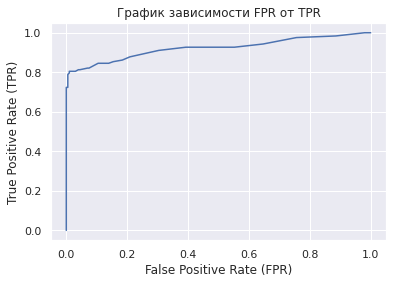

In [110]:
fpr, tpr, threshold = roc_curve(y_test, y_test_pred[:, 1], pos_label=1)
plt.plot(fpr, tpr)
plt.title("График зависимости FPR от TPR")
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.show()

В результате подбоа модели и параметров оказалось, что лучшее значение показала модель KNeighborsClassifier(n_neighbors=47). Метрика ROC-AUC на тренировочной выборке равна 0.90, на тестовой - 0.92.

### Шаг 7. Анализ важности признаков

Библиотека shap может объяснять модели на базе деревьев (TreeExplainer), линейные (LinearExplainer, требуются независимые - они же несвязанные - признаки), нейронные сети keras (DeepExplainer), а также произвольные модели (KernelExplainer) - но увы весьма медленно.
Поскольку наилучшей оказалась модель KNeighborsClassifier, то надо пользоваться универсальным KernelExplainer, который требует использовать метод predict_proba (предсказывает неоткалиброванную вероятность - или уверенность - в классе).
Поскольку  KernelExplainer работает медленно, то для построения диаграмм важности признаков будем использовать случайную выборку из данных (25 строк).

Для использования модели воспроизведем предобработку данных и выведем новые названия признаков.

In [111]:
# Лучшая модель из RandomizedSearchCV
model = randomized_search.best_estimator_.named_steps['models']

In [112]:
# Предобработка данных
preprocessor = randomized_search.best_estimator_.named_steps['preprocessor']
X_train_pre = preprocessor.transform(X_train)
X_test_pre = preprocessor.transform(X_test)

In [113]:
# Получаем имена признаков после OneHotEncoder
ohe_col_names = preprocessor.named_transformers_['ohe'].get_feature_names_out(input_features=cat_col)

In [114]:
ord_col_names = preprocessor.named_transformers_['ord'].get_feature_names_out(input_features=ord_col)
num_col_names = preprocessor.named_transformers_['num'].get_feature_names_out(input_features=num_col)

In [115]:
# Объединяем все имена признаков в один список
all_col_names = np.concatenate([ohe_col_names, num_col_names, ord_col_names])

In [116]:
all_col_names

array(['Разрешить_сообщать_нет',
       'Популярная_категория_Косметика и аксесуары',
       'Популярная_категория_Кухонная посуда',
       'Популярная_категория_Мелкая бытовая техника и электроника',
       'Популярная_категория_Техника для красоты и здоровья',
       'Популярная_категория_Товары для детей', 'Маркет_актив_6_мес',
       'Маркет_актив_тек_мес', 'Длительность', 'Акционные_покупки',
       'Средний_просмотр_категорий_за_визит',
       'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса',
       'Страниц_за_визит', 'Время_пред', 'Время_тек', 'Выручка_1',
       'Выручка_2', 'Выручка_3', 'Тип_сервиса'], dtype=object)

In [117]:
# Создаем DataFrame с соответствующими именами колонок
X_train_pre_df = pd.DataFrame(X_train_pre, columns=all_col_names)
X_test_pre_df = pd.DataFrame(X_test_pre, columns=all_col_names)

In [118]:
X_train_pre_df

Разрешить_сообщать_нет  Популярная_категория_Косметика и аксесуары  \
0                       0.0                                         0.0   
1                       0.0                                         0.0   
2                       0.0                                         0.0   
3                       0.0                                         0.0   
4                       0.0                                         0.0   
..                      ...                                         ...   
967                     0.0                                         1.0   
968                     0.0                                         0.0   
969                     0.0                                         0.0   
970                     1.0                                         0.0   
971                     0.0                                         0.0   

     Популярная_категория_Кухонная посуда  \
0                                     0.0   
1                                     0.0   
2                                     0.0   
3                                     1.0   
4                                     0.0   
..                                    ...   
967                                   0.0   
968                                   0.0   
969                                   0.0   
970                                   0.0   
971                                   0.0   

     Популярная_категория_Мелкая бытовая техника и электроника  \
0                                                  1.0           
1                                                  0.0           
2                                                  1.0           
3                                                  0.0           
4                                                  0.0           
..                                                 ...           
967                                                0.0           
968                                                1.0           
969                                                0.0           
970                                                1.0           
971                                                1.0           

     Популярная_категория_Техника для красоты и здоровья  \
0                                                  0.0     
1                                                  1.0     
2                                                  0.0     
3                                                  0.0     
4                                                  0.0     
..                                                 ...     
967                                                0.0     
968                                                0.0     
969                                                0.0     
970                                                0.0     
971                                                0.0     

     Популярная_категория_Товары для детей  Маркет_актив_6_мес  \
0                                      0.0                 0.0   
1                                      0.0                 0.0   
2                                      0.0                 0.0   
3                                      0.0                 0.0   
4                                      1.0                 1.0   
..                                     ...                 ...   
967                                    0.0                 0.0   
968                                    0.0                 0.0   
969                                    1.0                 0.0   
970                                    0.0                 0.0   
971                                    0.0                 0.0   

     Маркет_актив_тек_мес  Длительность  Акционные_покупки  \
0                1.228498     -0.034940          -0.386673   
1                0.829033     -0.034940          -1.626840   
2                0.030104      1.380136           1.555325   
3       

Создаем случайные выборки из 25 строк для использования KernelExplainer.

In [119]:
X_train_sample = shap.sample(X_train_pre_df, 25, random_state=RANDOM_STATE)
X_test_sample = shap.sample(X_test_pre_df, 25, random_state=RANDOM_STATE)

In [120]:
#X_test_sample

In [121]:
X_test_sample.columns

Index(['Разрешить_сообщать_нет', 'Популярная_категория_Косметика и аксесуары',
       'Популярная_категория_Кухонная посуда',
       'Популярная_категория_Мелкая бытовая техника и электроника',
       'Популярная_категория_Техника для красоты и здоровья',
       'Популярная_категория_Товары для детей', 'Маркет_актив_6_мес',
       'Маркет_актив_тек_мес', 'Длительность', 'Акционные_покупки',
       'Средний_просмотр_категорий_за_визит',
       'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса',
       'Страниц_за_визит', 'Время_пред', 'Время_тек', 'Выручка_1', 'Выручка_2',
       'Выручка_3', 'Тип_сервиса'],
      dtype='object')

In [122]:
#X_train_sample

In [123]:
explainer = shap.KernelExplainer(model.predict_proba, X_train_sample)
shap_values = explainer.shap_values(X_test_sample)

  0%|          | 0/25 [00:00<?, ?it/s]

In [124]:
#shap_values

In [125]:
X_test_sample.shape

(25, 20)

In [126]:
shap_values.size

1000

In [127]:
shap_values.shape

(25, 20, 2)

Строим диаграммы, показывающую вклады признаков в каждое предсказание модели. На красно-синем графике точками отображены 25 случайных наблюдений из выборки. Поэтому при увеличении числа наблюдений диаграмма можен немного поменяться. Но даже обработка выборки из 25 строк занимает достаточно много времени.

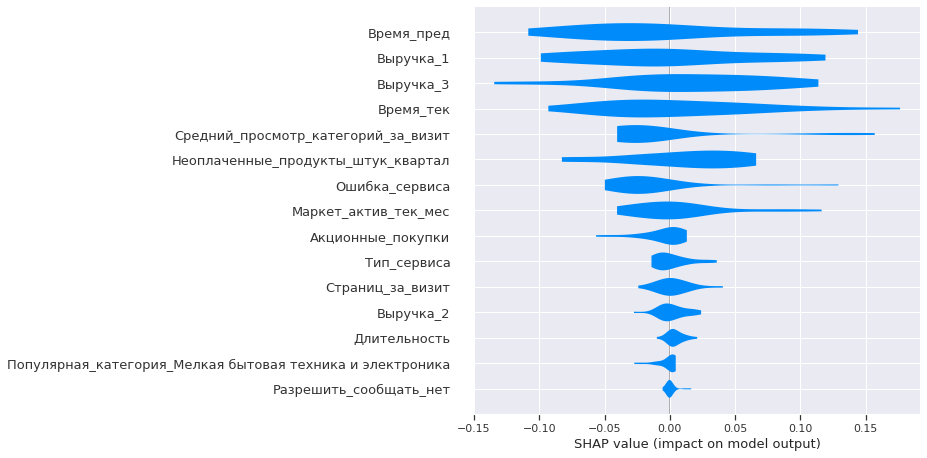

In [128]:
feat_names = list(X_test_sample.columns)
shap.plots.violin(shap_values[:,:,1], feature_names=feat_names, max_display=15)

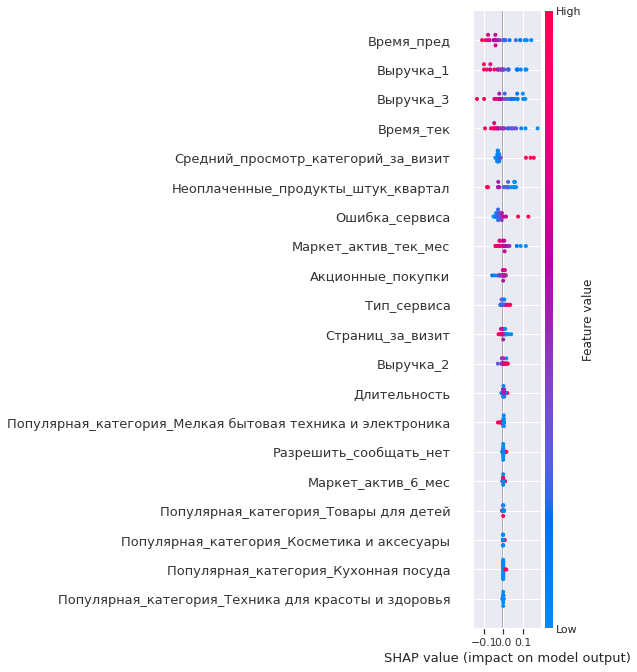

In [129]:
shap.summary_plot(shap_values[:,:,1], X_test_sample)

Анализ диаграммы показывает:

Чем больше значения признаков Время_пред,  Выручка_1, Средний_просмотр_категорий_за_визит, тем меньше SHAP‑значения объектов. Если у наблюдения высокое значение этих признаков, то у него высокая вероятность принадлежности к классу 0 (прежний уровень).

Чем больше значение признака Неоплаченные_продукты_штук_квартал, тем выше SHAP-значения. Если у наблюдения высокое значение этого признака, то у него высокая вероятность принадлежности к классу 1 (снизилась).

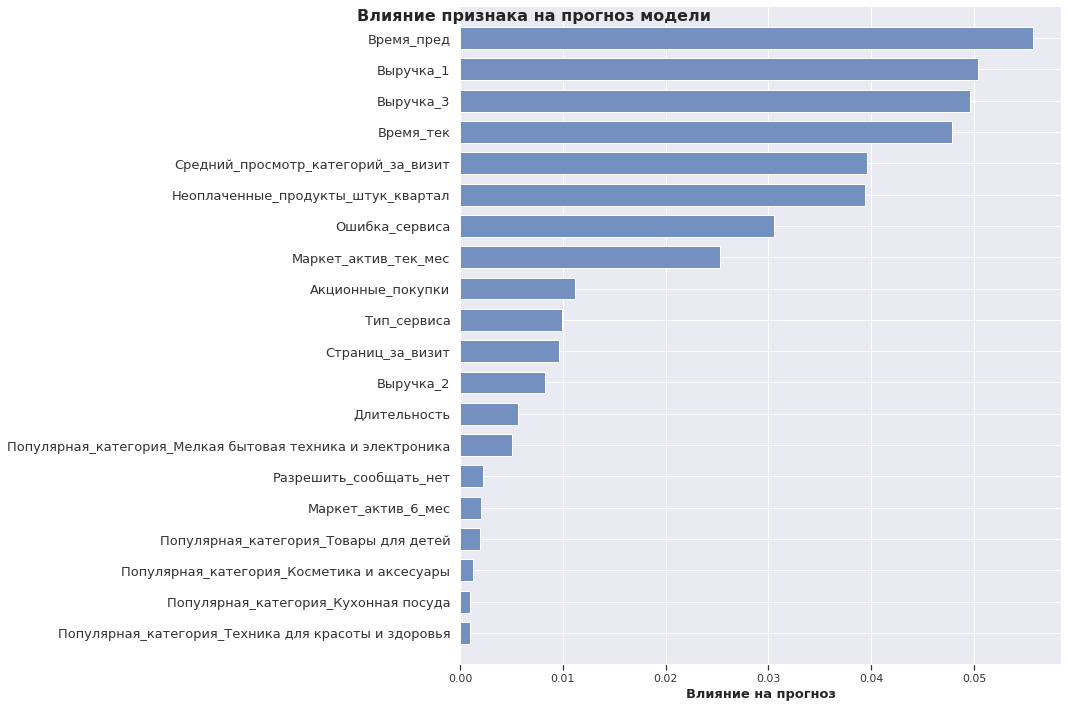

In [130]:
# Столбчатая диаграмма важности признаков
ax = shap.summary_plot(shap_values[:,:,1], X_test_sample, plot_type="bar", plot_size=(15, 10), color='#7490C0', show=False)
plt.suptitle("Влияние признака на прогноз модели", fontweight='bold', fontsize=16)
plt.xlabel('Влияние на прогноз', fontweight='bold')
plt.show()

Столбчатая диаграмма отражает общий вклад признаков в прогнозы модели. Она показывает средние SHAP-значения признака по всем наблюдениям. Наибольший вклад вносят признаки: Время_пред, Выручка_1, Выручка_3, Время_тек, Средний_просмотр_категорий_за_визит и Неоплаченные_продукты_штук_квартал.    

Поскольку наилучшей оказалась модель KNeighborsClassifier, то будем использовать универсальный KernelExplainer, который требует использовать метод predict_proba (предсказывает неоткалиброванную вероятность - или уверенность - в классе). Поскольку KernelExplainer работает медленно, то для построения диаграмм важности признаков будем использовать случайную выборку из данных (25 строк).
Анализ SHAP диаграммы показывает:
Чем больше значения признаков Время_пред,  Выручка_1, Средний_просмотр_категорий_за_визит, тем меньше SHAP‑значения объектов. Если у наблюдения высокое значение этих признаков, то у него высокая вероятность принадлежности к классу 0 (прежний уровень).
Чем больше значение признака Неоплаченные_продукты_штук_квартал, тем выше SHAP-значения. Если у наблюдения высокое значение этого признака, то у него высокая вероятность принадлежности к классу 1 (снизилась).
Столбчатая диаграмма отражает общий вклад признаков в прогнозы модели. Она показывает средние SHAP-значения признака по всем наблюдениям. Наибольший вклад вносят признаки: Время_пред, Выручка_1, Выручка_3, Время_тек, Средний_просмотр_категорий_за_визит и Неоплаченные_продукты_штук_квартал.

### Шаг 8. Сегментация покупателей

Рассмотрим следующий сегмент для анализа: группу клиентов, которые покупают только технику, то есть товары с длинным жизненным циклом.

Предварительно подготовим полный датасет из всех имеющихся данных: исходный + прибыль + прогнозная вероятность снижения покупательской активности.

In [131]:
X = data_full.drop(['Покупательская_активность'], axis=1)

Применим лучшую модель к получившимся данным и получим столбец с вероятностями принадлежности к классу 1 (покупательская способность снизилась). 

In [132]:
best_model = randomized_search.best_estimator_

In [133]:
Y_pred = best_model.predict_proba(X)

In [134]:
Y_pred = pd.DataFrame(Y_pred[:, 1], columns = ['y_test_progn'])

In [135]:
Y_pred

y_test_progn
0         0.936170
1         0.361702
2         0.765957
3         0.936170
4         0.617021
...            ...
1291      0.148936
1292      0.042553
1293      0.021277
1294      0.170213
1295      0.382979

[1296 rows x 1 columns]

Создадим финальную объединенную таблицу. Сначала добавим столбец с прогнозом. Добавим в столбец Прогноз значение Снизилась, если вероятность принадлежности к классу 1 превышает значение 0.5, чтобы было меньше ложноположительных прогнозов. В противном случае добавляем значение прежний уровень.
Затем объединяем по id получившуюся таблицу с таблицей money, содержащей данные о прибыли.

In [136]:
table_fin = X.copy()

In [137]:
table_fin

id Тип_сервиса Разрешить_сообщать  Маркет_актив_6_мес  \
0     215349     премиум                 да                 4.4   
1     215350    стандарт                нет                 4.9   
2     215351    стандарт                 да                 3.2   
3     215352    стандарт                нет                 5.1   
4     215353    стандарт                 да                 3.3   
...      ...         ...                ...                 ...   
1291  216643    стандарт                 да                 6.6   
1292  216644    стандарт                нет                 5.1   
1293  216645    стандарт                 да                 4.1   
1294  216646    стандарт                 да                 6.3   
1295  216647     премиум                 да                 4.0   

      Маркет_актив_тек_мес  Длительность  Акционные_покупки  \
0                        4           819               0.75   
1                        3           539               0.14   
2                        5           896               0.99   
3                        3          1064               0.94   
4                        4           762               0.26   
...                    ...           ...                ...   
1291                     3           318               0.24   
1292                     4           454               0.21   
1293                     3           586               0.20   
1294                     5           645               0.12   
1295                     5           906               0.94   

                Популярная_категория  Средний_просмотр_категорий_за_визит  \
0                   Товары для детей                                    4   
1                  Домашний текстиль                                    5   
2                   Товары для детей                                    5   
3                   Товары для детей                                    3   
4                  Домашний текстиль                                    4   
...                              ...                                  ...   
1291  Техника для красоты и здоровья                                    5   
1292               Домашний текстиль                                    6   
1293               Домашний текстиль                                    3   
1294  Техника для красоты и здоровья                                    3   
1295  Техника для красоты и здоровья                                    4   

      Неоплаченные_продукты_штук_квартал  Ошибка_сервиса  Страниц_за_визит  \
0                                      4               2                 5   
1                                      2               1                 5   
2                                      0               6                 4   
3                                      2               3                 2   
4                                      1               1                 4   
...                                  ...             ...               ...   
1291                                   3               3                11   
1292                                   2               3                 9   
1293                                   2               5                 7   
1294                                   3               5                 7   
1295                                   5               3                12   

      Выручка_1  Выручка_2  Выручка_3  Время_пред  Время_тек  
0        5216.0     4472.0     4971.6          12         10  
1        5457.5     4826.0     5058.4           8         13  
2        6158.0     4793.0     6610.4          11         13  
3        5807.5     4594.0     5872.5           8         11  
4        4738.5     5124.0     5388.5          10         10  
...         ...        ...        ...         ...        ...  
1291     3664.0     4704.0     4741.7          14          7  
1292     4729.0     5299.0     5353.0          12         11  
1293     5160.0    

In [138]:
table_fin['Прогноз'] = Y_pred['y_test_progn'].apply(lambda x: 'снизилась' if x > 0.5 else 'прежний уровень')

In [139]:
table_fin.head()

id Тип_сервиса Разрешить_сообщать  Маркет_актив_6_мес  \
0  215349     премиум                 да                 4.4   
1  215350    стандарт                нет                 4.9   
2  215351    стандарт                 да                 3.2   
3  215352    стандарт                нет                 5.1   
4  215353    стандарт                 да                 3.3   

   Маркет_актив_тек_мес  Длительность  Акционные_покупки Популярная_категория  \
0                     4           819               0.75     Товары для детей   
1                     3           539               0.14    Домашний текстиль   
2                     5           896               0.99     Товары для детей   
3                     3          1064               0.94     Товары для детей   
4                     4           762               0.26    Домашний текстиль   

   Средний_просмотр_категорий_за_визит  Неоплаченные_продукты_штук_квартал  \
0                                    4                                   4   
1                                    5                                   2   
2                                    5                                   0   
3                                    3                                   2   
4                                    4                                   1   

   Ошибка_сервиса  Страниц_за_визит  Выручка_1  Выручка_2  Выручка_3  \
0               2                 5     5216.0     4472.0     4971.6   
1               1                 5     5457.5     4826.0     5058.4   
2               6                 4     6158.0     4793.0     6610.4   
3               3                 2     5807.5     4594.0     5872.5   
4               1                 4     4738.5     5124.0     5388.5   

   Время_пред  Время_тек          Прогноз  
0          12         10        снизилась  
1           8         13  прежний уровень  
2          11         13        снизилась  
3           8         11        снизилась  
4          10         10        снизилась

In [140]:
table_fin = table_fin.merge(money, on='id')

In [141]:
table_fin

id Тип_сервиса Разрешить_сообщать  Маркет_актив_6_мес  \
0     215349     премиум                 да                 4.4   
1     215350    стандарт                нет                 4.9   
2     215351    стандарт                 да                 3.2   
3     215352    стандарт                нет                 5.1   
4     215353    стандарт                 да                 3.3   
...      ...         ...                ...                 ...   
1291  216643    стандарт                 да                 6.6   
1292  216644    стандарт                нет                 5.1   
1293  216645    стандарт                 да                 4.1   
1294  216646    стандарт                 да                 6.3   
1295  216647     премиум                 да                 4.0   

      Маркет_актив_тек_мес  Длительность  Акционные_покупки  \
0                        4           819               0.75   
1                        3           539               0.14   
2                        5           896               0.99   
3                        3          1064               0.94   
4                        4           762               0.26   
...                    ...           ...                ...   
1291                     3           318               0.24   
1292                     4           454               0.21   
1293                     3           586               0.20   
1294                     5           645               0.12   
1295                     5           906               0.94   

                Популярная_категория  Средний_просмотр_категорий_за_визит  \
0                   Товары для детей                                    4   
1                  Домашний текстиль                                    5   
2                   Товары для детей                                    5   
3                   Товары для детей                                    3   
4                  Домашний текстиль                                    4   
...                              ...                                  ...   
1291  Техника для красоты и здоровья                                    5   
1292               Домашний текстиль                                    6   
1293               Домашний текстиль                                    3   
1294  Техника для красоты и здоровья                                    3   
1295  Техника для красоты и здоровья                                    4   

      Неоплаченные_продукты_штук_квартал  Ошибка_сервиса  Страниц_за_визит  \
0                                      4               2                 5   
1                                      2               1                 5   
2                                      0               6                 4   
3                                      2               3                 2   
4                                      1               1                 4   
...                                  ...             ...               ...   
1291                                   3               3                11   
1292                                   2               3                 9   
1293                                   2               5                 7   
1294                                   3               5                 7   
1295                                   5               3                12   

      Выручка_1  Выручка_2  Выручка_3  Время_пред  Время_тек          Прогноз  \
0        5216.0     4472.0     4971.6          12         10        снизилась   
1        5457.5     4826.0     5058.4           8         13  прежний уровень   
2        6158.0     4793.0     6610.4          11         13        снизилась   
3        5807.5     4594.0     5872.5           8         11        снизилась   
4        4738.5     5124.0     5388.5          10         10        снизилась   
...         ...        ...        ...         ...        ...              ...   
1291     3664.0    

Создадим список, в который входят значения признака Популярная_категория, относящиеся к технике.
Доля этих сегментов, как было показано в разделе анализа признаков, составляет 13,4+14,2=27,6%.

In [142]:
list = ['Техника для красоты и здоровья', 'Мелкая бытовая техника и электроника']

Разобъем выборку из финальной таблицы, относящуюся к рассматриваемому сегменту, на две: table_tech_1, где признак Прогноз равен значению прежний уровень и table_tech_2, где признак Прогноз равен значению снизилась.

In [143]:
table_tech_1 = table_fin.query('Прогноз == "прежний уровень" and Популярная_категория in @list').sort_values(['Прибыль'], ascending=False)

In [144]:
table_tech_1

id Тип_сервиса Разрешить_сообщать  Маркет_актив_6_мес  \
633   215985    стандарт                 да                 5.5   
1181  216533    стандарт                нет                 5.7   
1065  216417     премиум                 да                 4.6   
834   216186    стандарт                 да                 4.3   
397   215749     премиум                 да                 5.8   
...      ...         ...                ...                 ...   
1105  216457    стандарт                нет                 5.7   
423   215775    стандарт                нет                 5.0   
934   216286    стандарт                нет                 4.1   
770   216122    стандарт                 да                 5.8   
972   216324     премиум                 да                 4.3   

      Маркет_актив_тек_мес  Длительность  Акционные_покупки  \
633                      5           541               0.17   
1181                     5           769               0.14   
1065                     3           485               0.23   
834                      4           831               0.21   
397                      5           624               0.30   
...                    ...           ...                ...   
1105                     4           259               0.14   
423                      4           157               0.15   
934                      5           402               0.30   
770                      5           365               0.17   
972                      5           509               0.25   

                      Популярная_категория  \
633   Мелкая бытовая техника и электроника   
1181        Техника для красоты и здоровья   
1065  Мелкая бытовая техника и электроника   
834   Мелкая бытовая техника и электроника   
397         Техника для красоты и здоровья   
...                                    ...   
1105  Мелкая бытовая техника и электроника   
423   Мелкая бытовая техника и электроника   
934         Техника для красоты и здоровья   
770         Техника для красоты и здоровья   
972   Мелкая бытовая техника и электроника   

      Средний_просмотр_категорий_за_визит  Неоплаченные_продукты_штук_квартал  \
633                                     4                                   1   
1181                                    4                                   1   
1065                                    2                                   5   
834                                     5                                   2   
397                                     4                                   3   
...                                   ...                                 ...   
1105                                    4                                   1   
423                                     5                                   0   
934                                     4                                   1   
770                                     6                                   2   
972                                     3                                   5   

      Ошибка_сервиса  Страниц_за_визит  Выручка_1  Выручка_2  Выручка_3  \
633                6                 5     5388.0     5223.0     5661.0   
1181               8                10     5868.0     4925.0     5180.3   
1065               7                13     4163.5     4486.0     4014.0   
834                3                 7     3872.0     4697.0     3287.0   
397                6                14     5190.0     4928.0     5092.5   
...              ...               ...        ...        ...        ...   
1105               4                10     5389.0     4867.0     5971.4   
423                5                13     4028.0     4934.0     3372.8   
934                7                 6     4516.0     4852.0     4937.2   
770                4                 8     4593.0     4545.0     4681.4   
972                4                 9     4852.5     4473.0     5311.4   

      Время_пред  Вре

In [145]:
table_tech_2 = table_fin.query('Прогноз == "снизилась" and Популярная_категория in @list').sort_values(['Прибыль'], ascending=False)

In [146]:
table_tech_2

id Тип_сервиса Разрешить_сообщать  Маркет_актив_6_мес  \
17    215368     премиум                 да                 3.8   
261   215613    стандарт                 да                 4.4   
386   215738     премиум                нет                 4.6   
288   215640    стандарт                 да                 2.4   
393   215745    стандарт                 да                 1.7   
346   215698    стандарт                 да                 3.5   
345   215697     премиум                 да                 3.9   
158   215510    стандарт                 да                 3.8   
172   215524    стандарт                 да                 3.0   
1061  216413     премиум                 да                 5.2   
387   215739    стандарт                нет                 3.4   
46    215398     премиум                 да                 3.5   
147   215499    стандарт                 да                 3.4   
188   215540     премиум                 да                 1.4   
144   215496     премиум                 да                 4.0   
94    215446    стандарт                 да                 3.5   
582   215934    стандарт                нет                 5.5   
250   215602     премиум                 да                 3.5   
249   215601     премиум                 да                 0.9   
31    215383    стандарт                 да                 2.7   
225   215577    стандарт                 да                 3.9   
228   215580     премиум                 да                 4.4   
145   215497     премиум                 да                 5.6   
234   215586     премиум                 да                 4.1   
378   215730    стандарт                 да                 3.1   
364   215716    стандарт                 да                 2.4   
763   216115    стандарт                нет                 4.4   
1247  216599    стандарт                 да                 3.3   
10    215361    стандарт                 да                 5.1   
115   215467    стандарт                 да                 4.4   
281   215633     премиум                 да                 4.4   
226   215578    стандарт                 да                 2.4   
51    215403     премиум                 да                 1.7   
14    215365    стандарт                 да                 3.9   
390   215742    стандарт                 да                 4.6   
301   215653    стандарт                нет                 5.6   
1209  216561    стандарт                 да                 4.0   
143   215495    стандарт                 да                 0.9   
689   216041    стандарт                нет                 2.6   
176   215528    стандарт                 да                 4.4   
720   216072    стандарт                 да                 4.7   
220   215572    стандарт                 да                 3.5   
69    215421     премиум                нет                 4.0   
157   215509     премиум                 да                 4.0   
27    215378    стандарт                 да                 1.7   
114   215466     премиум                нет                 2.4   
41    215393    стандарт                нет                 4.6   
292   215644     премиум                 да                 3.5   
309   215661    стандарт                 да                 3.5   
212   215564    стандарт                нет                 3.9   
374   215726    стандарт                 да                 5.6   
1140  216492    стандарт                 да                 4.0   
434   215786     премиум                 да                 3.4   

      Маркет_актив_тек_мес  Длительность  Акционные_покупки  \
17                       5           829               0.24   
261                      4           627               0.93   
386                      5           187               0.23   
288                      4           251               0.32   
393                      4           550               0.94   
346          

Посмотрим на распределение признаков, имеющих самую высокую важность для модели и имеющих высокую корреляцию с целевым признаком. Для сравнения построим распределения отдельно - для покупателей техники с разным прогнозом снижения покупательской активности.

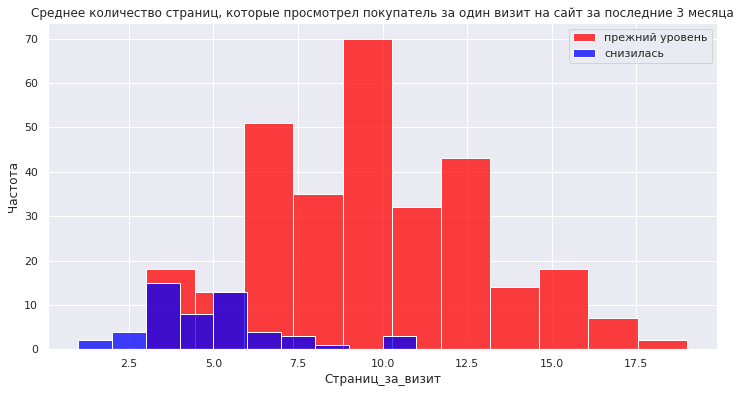

In [147]:
plt.figure(figsize=(12,6))
sns.set_theme(style="darkgrid")

sns.histplot(data=table_tech_1, x="Страниц_за_визит", color="red", label="прежний уровень")
sns.histplot(data=table_tech_2, x="Страниц_за_визит", color="blue", label="снизилась")

plt.ylabel('Частота')
plt.xlabel('Страниц_за_визит')
plt.title('Среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца')
plt.legend() 
plt.show()

Видно, что распределение среднего количества страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца, у покупателей со снижением активности значительно сместилось влево - в сторону меньшего количества страниц.

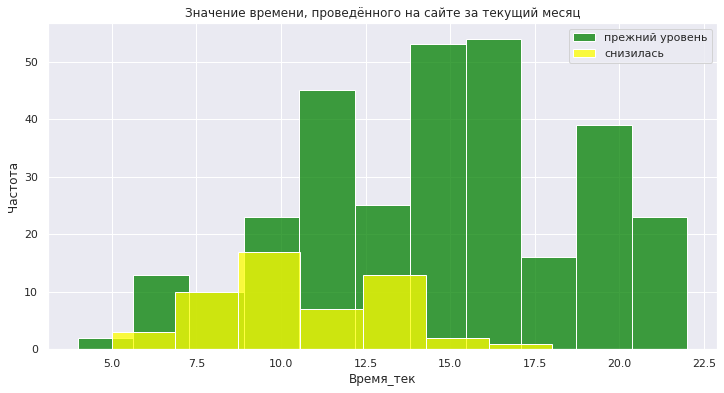

In [148]:
plt.figure(figsize=(12,6))
sns.set_theme(style="darkgrid")

sns.histplot(data=table_tech_1, x="Время_тек", color="green", label="прежний уровень")
sns.histplot(data=table_tech_2, x="Время_тек", color="yellow", label="снизилась")

plt.ylabel('Частота')
plt.xlabel('Время_тек')
plt.title('Значение времени, проведённого на сайте за текущий месяц')
plt.legend() 
plt.show()

Соответвественно, у покупателей со снижением активности произошло сильное снижение значения времени, проведённого на сайте за текущий месяц.

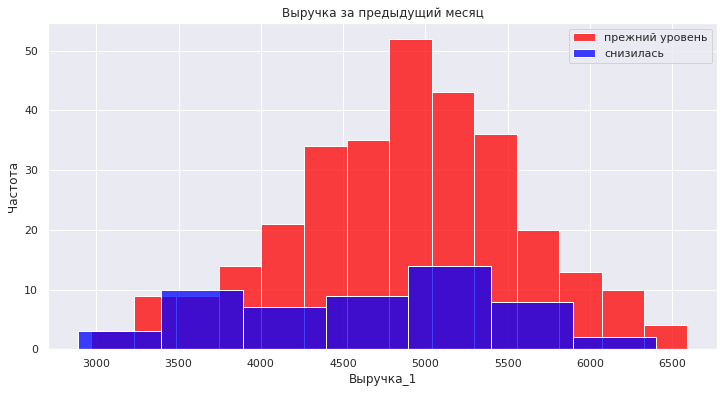

In [149]:
plt.figure(figsize=(12,6))
sns.set_theme(style="darkgrid")

sns.histplot(data=table_tech_1, x="Выручка_1", color="red", label="прежний уровень")
sns.histplot(data=table_tech_2, x="Выручка_1", color="blue", label="снизилась")

plt.ylabel('Частота')
plt.xlabel('Выручка_1')
plt.title('Выручка за предыдущий месяц')
plt.legend() 
plt.show()

Видно, что у покупателей со снижением активности распределение выручки за предыдущий месяц выглядит более плоским. Выросла относительная доля покупателей с маленькой выручкой.

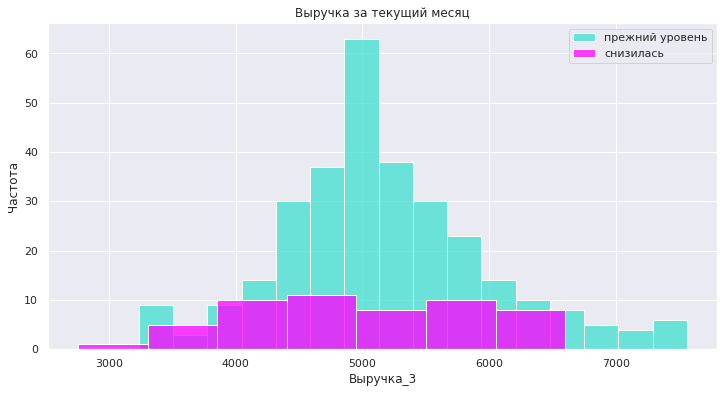

In [150]:
plt.figure(figsize=(12,6))
sns.set_theme(style="darkgrid")

sns.histplot(data=table_tech_1, x="Выручка_3", color="turquoise", label="прежний уровень")
sns.histplot(data=table_tech_2, x="Выручка_3", color="magenta", label="снизилась")

plt.ylabel('Частота')
plt.xlabel('Выручка_3')
plt.title('Выручка за текущий месяц')
plt.legend() 
plt.show()

Видно, что у покупателей со снижением активности распределение выручки за текущий месяц выглядит более плоским. Выросла относительная доля покупателей с маленькой выручкой.

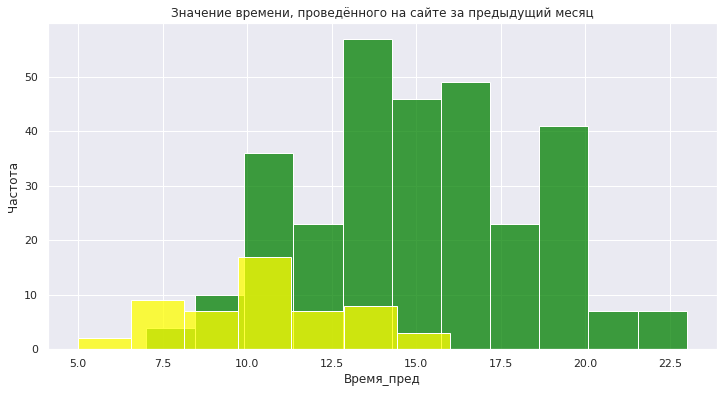

In [151]:
plt.figure(figsize=(12,6))
sns.set_theme(style="darkgrid")

sns.histplot(data=table_tech_1, x="Время_пред", color="green", label="прежний уровень")
sns.histplot(data=table_tech_2, x="Время_пред", color="yellow", label="снизилась")

plt.ylabel('Частота')
plt.xlabel('Время_пред')
plt.title('Значение времени, проведённого на сайте за предыдущий месяц')
plt.show()

Соответсвенно, у покупателей со снижением активности произошло снижение значения времени, проведённого на сайте за предыдущий месяц.

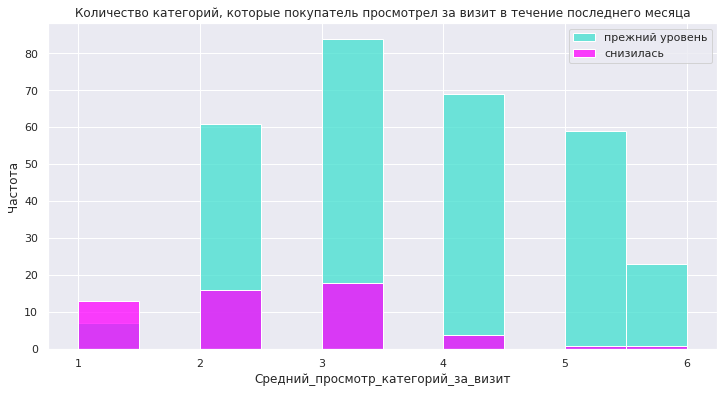

In [152]:
plt.figure(figsize=(12,6))
sns.set_theme(style="darkgrid")

sns.histplot(data=table_tech_1, x="Средний_просмотр_категорий_за_визит", color="turquoise", label="прежний уровень")
sns.histplot(data=table_tech_2, x="Средний_просмотр_категорий_за_визит", color="magenta", label="снизилась")

plt.ylabel('Частота')
plt.xlabel('Средний_просмотр_категорий_за_визит')
plt.title('Количество категорий, которые покупатель просмотрел за визит в течение последнего месяца')
plt.legend() 
plt.show()

Также, у покупателей со снижением активности произошло снижение количества категорий, которые покупатель просмотрел за визит в течение последнего месяца.

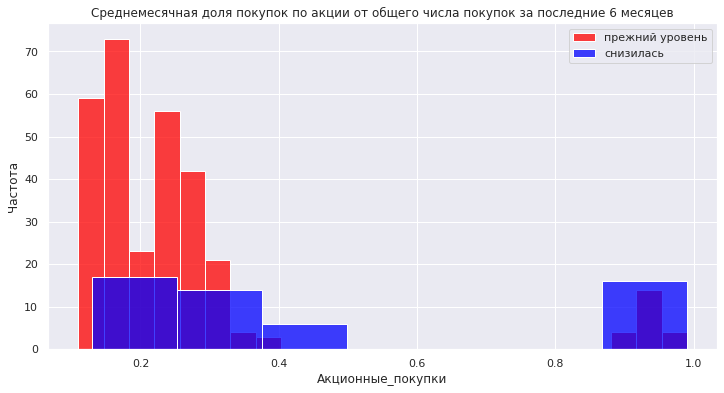

In [153]:
plt.figure(figsize=(12,6))
sns.set_theme(style="darkgrid")

sns.histplot(data=table_tech_1, x="Акционные_покупки", color="red", label="прежний уровень")
sns.histplot(data=table_tech_2, x="Акционные_покупки", color="blue", label="снизилась")

plt.ylabel('Частота')
plt.xlabel('Акционные_покупки')
plt.title('Среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев')
plt.legend() 
plt.show()

Пожалуй, сильнее всего отличаются распределения для признака Акционные_покупки. Видно, что среди покупателей техники есть такие, которые покупают только акционные товары. Причем эта тенденция гораздо более выражена у покупателей с прогнозируемым снижением активности.

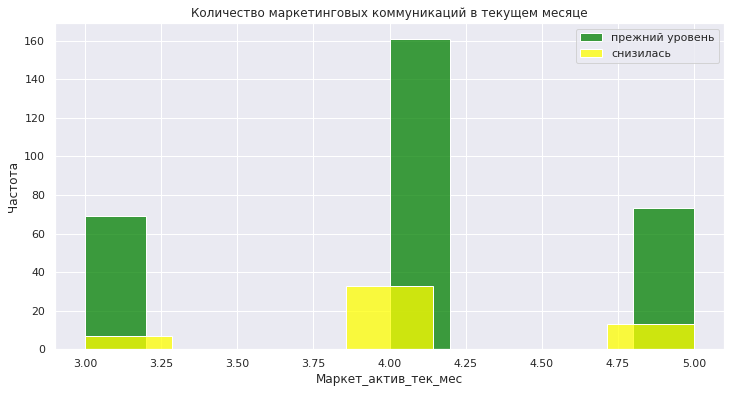

In [154]:
plt.figure(figsize=(12,6))
sns.set_theme(style="darkgrid")

sns.histplot(data=table_tech_1, x="Маркет_актив_тек_мес", color="green", label="прежний уровень")
sns.histplot(data=table_tech_2, x="Маркет_актив_тек_мес", color="yellow", label="снизилась")

plt.ylabel('Частота')
plt.xlabel('Маркет_актив_тек_мес')
plt.title('Количество маркетинговых коммуникаций в текущем месяце')
plt.legend() 
plt.show()

Распределение признака Количество маркетинговых коммуникаций в текущем месяце выглядит практически одинаково как для покупателей с прогнозируемым снижением активности, так и для покупателей с прежней активностью. Скорее всего, увеличение количества маркетинговых коммуникаций не приведет к росту покупательской активности.

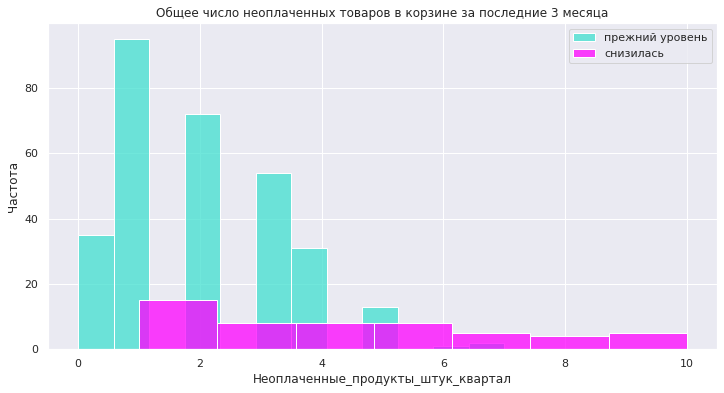

In [155]:
plt.figure(figsize=(12,6))
sns.set_theme(style="darkgrid")

sns.histplot(data=table_tech_1, x="Неоплаченные_продукты_штук_квартал", color="turquoise", label="прежний уровень")
sns.histplot(data=table_tech_2, x="Неоплаченные_продукты_штук_квартал", color="magenta", label="снизилась")

plt.ylabel('Частота')
plt.xlabel('Неоплаченные_продукты_штук_квартал')
plt.title('Общее число неоплаченных товаров в корзине за последние 3 месяца')
plt.legend() 
plt.show()

Из распределения видно, что у покупателей техники с прогнозируемым снижением активности гораздо больше таких, кто имеет много неоплаченных товаров в корзине за последние 3 месяца - до 10 товаров. 

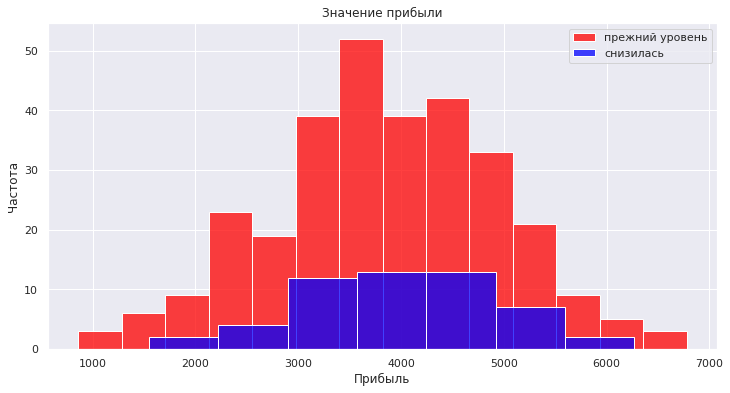

In [156]:
plt.figure(figsize=(12,6))
sns.set_theme(style="darkgrid")

sns.histplot(data=table_tech_1, x="Прибыль", color="red", label="прежний уровень")
sns.histplot(data=table_tech_2, x="Прибыль", color="blue", label="снизилась")

plt.ylabel('Частота')
plt.xlabel('Прибыль')
plt.title('Значение прибыли')
plt.legend() 
plt.show()

Распределение прибыли выглядит похоже для покупателей с различным прогнозом активности.

In [157]:
sum_tech = table_tech_1['Прибыль'].sum() + table_tech_1['Прибыль'].sum()

In [158]:
sum_all = table_fin['Прибыль'].sum()

In [159]:
part = 100*sum_tech/sum_all

In [160]:
print('Доля прибыли, приходящаяся на клиентов, которые покупают только технику:', round(part, 2), '%')

Доля прибыли, приходящаяся на клиентов, которые покупают только технику: 44.95 %


Из приведенных гистограмм видно, снижение покупательской активности клиентов, которые покупают только технику, сильно коррелирует с признаками, которые описывают поведение покупателя на сайте: Среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца, и Значение времени, проведённого на сайте, в минутах (как для предыдущего, так и для текущего месяца). Распределения этих признаков сдвинулись влево. Покупатели из рассматриваемого сегмента стали меньше проводить время на сайте и просматривать меньше страниц.
Также сильно изменились такие признаки, которые описывают продуктовое поведение покупателя, как Количество категорий, которые покупатель просмотрел за визит в течение последнего месяца и Общее число неоплаченных товаров в корзине за последние 3 месяца. Количество категорий снизилось, а количество неоплаченных товаров в корзине выросло.
Видно, что у покупателей со снижением активности распределение выручки за предыдущий и текущий месяцы выглядит более плоским. Выросла относительная доля покупателей с маленькой выручкой.
Наибольшего внимания, на мой взгляд, заслуживает признак Среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев. Распределение этого признака для покупателей с прогнозируемым снижением активности сильно отличается от распределения  для покупателей с прогнозируемым сохранением активности. Видно, что число покупателей, покупающих продукты по акции такое же, как и число тех, кто не пользуется акциями. Тогда как в сегменте покупателей с прогнозируемым сохранением активности относительное число покупателей, покупающих продукты по акции невысоко.
Таким образом, для того чтобы увеличить покупательскую активность в рассматриваемом сегменте необходимо персонально проанализировать неоплаченные продукты в корзине и разработать акционные предложения, касающиеся этих товаров.

### ВЫВОДЫ

Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.
«В один клик» — современная компания, поэтому её руководство не хочет принимать решения просто так — только на основе анализа данных и бизнес-моделирования. У компании есть небольшой отдел цифровых технологий, и вам предстоит побыть в роли стажёра в этом отделе.
Итак, вашему отделу поручили разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

Для исследования нам даны четыре датафрейма: market_file - с данными о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении; market_money - с данными о выручке, которую получает магазин с покупателя; market_time - с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода и money - с данными о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю. В столбце прибыль требуется замена типа данных на float64.

В процессе предобработки данных был изменен тип данных в столбце Прибыль датафрейма money с object на float64. Пропусков в данных не обнаружено. Были изменены названия некоторых столбцов. Также были исправлены орфографические ошибки в уникальных значениях признаков.

 Исследовательский анализ данных показал следующее:
Из диаграммы видно, что присутствует дисбаланс целевого признака Покупательская_активность. Следовательно при разбивке данных на тренировочную и тестовую выборки будем использовать использовать стратификацию по целевому признаку.
Более распространен тип сервиса стандарт - он составляет 71.1%.
Большинство клиентов - 74% согласно на получение дополнительных предложений.
Самую большую долю занимают товары для детей, самую маленькую - кухонная посуда. В дальнейшем будем анализировать сегмент покупателей, которые покупают только технику, то есть товары с длинным жизненным циклом. Доля этой категории составляет 13,4+14,2 = 27,6% - практически треть от всех категорий.
Признак Число маркетинговых коммуникаций/на клиента распределен неравномерно.
Признак Количество маркетинговых коммуникаций в текущем месяце/на клиента принимает дискретные значения.
Распределение признака Длительность непрерывное, достаточно симметричное
Распределение признака Акционные_покупки носит бимодальный характер. Есть группа клиентов, которые покупают товары только по акции.
Признак Средний_просмотр_категорий_за_визит принимает дискретные значения. Чаще всего за визит просматривается 3 категории.
Признак Неоплаченные_продукты_штук_квартал принимает дискретные значения, распределение несимметричное, смещено влево. Обычно в корзине 1-2 неоплаченных товара.
Признак Ошибка_сервиса принимает дискретные значения, распределение достаточно симметричное с максимумом - 4 сбоя.
Распределение признака Страниц_за_визит непрерывное, несимметричное, смещено влево. Чаще всего покупатель просматривает 5 страниц за один визит на сайт за последние 3 месяца.
Соотношение всех трех периодов, во время которых зафиксирована выручка - 1:1:1.
Удален выброс параметра Выручка. Распределение параметра Выручка является достаточно симметричным относительно центра. Среднее и медианное значения практически совпадают. Среднее значение равно 4999.6 руб. Из распределения параметра видно, что есть небольшое количество покупателей с нулевой выручкой за рассматриваемый период.
Соотношение периодов, во время которых зафиксировано общее время: 1:1.
Значение признака - времени, проведённого на сайте, в минутах, распалось на три группы. Чаще всего время находится в диапазоне 11-16 минут.
Распределение параметра Прибыль является достаточно симметричным относительно центра. Среднее и медианное значения практически совпадают. Среднее значение равно 4.0 тыс.руб.

Были объединены датафреймы market_file, market_money и market_time.

Для установления корреляций между целевым параметром Покупательская_активность и остальными признаками использовалась корреляция Phi_K. Построена матрица корреляций Phi_K.
Самая высокая корреляция (коэффициент больше 0.7) между целевым параметром Покупательская_активность и параметром Страниц_за_визит. Коэффициенты от (0.5 до 0.7) - у параметров Время_пред, Время_тек, Маркет_актив6мес, Средний_просмотр_категорий_за_визит, Неоплаченные_продукты_штук_квартал и Акционные_покупки. Все коэффициенты корреляции в матрице меньше 0.9, следовательно мультиколлинеарности не наблюдается.
На большинстве попарных диаграмм рассеяния точки четко разделяются в зависимости от значения целевого признака.

Целевой признак был закодирован при помощи LabelEncoder(). Для подбора гиперпараметров моделей будем использовать рандомизированный (случайный) поиск гиперпараметров с помощью RandomizedSearchCV, который является более быстродействующим по сравнению с GridSearchCV.
В качестве метрики будем использовать метрику ROC-AUC (Receiver Operating Characteristic - Area Under the Curve). Она оценивает способность модели различать между классами. Он измеряет площадь под ROC-кривой, которая показывает отношение между долей верно классифицированных положительных и долей ложноположительных результатов при изменении порогового значения. Эта метрика используется в задачах бинарной классификации для оценки способности модели разделять классы, независимо от баланса классов.
В результате подбора модели и параметров оказалось, что лучшее значение показала модель KNeighborsClassifier(n_neighbors=47). Метрика ROC-AUC на тренировочной выборке равна 0.90, на тестовой - 0.92.

Поскольку наилучшей оказалась модель KNeighborsClassifier, то будем использовать универсальный KernelExplainer, который требует использовать метод predict_proba (предсказывает неоткалиброванную вероятность - или уверенность - в классе). Поскольку KernelExplainer работает медленно, то для построения диаграмм важности признаков будем использовать случайную выборку из данных (25 строк).
Анализ SHAP диаграммы показывает:
Чем больше значения признаков Время_пред,  Выручка_1, Средний_просмотр_категорий_за_визит, тем меньше SHAP‑значения объектов. Если у наблюдения высокое значение этих признаков, то у него высокая вероятность принадлежности к классу 0 (прежний уровень).
Чем больше значение признака Неоплаченные_продукты_штук_квартал, тем выше SHAP-значения. Если у наблюдения высокое значение этого признака, то у него высокая вероятность принадлежности к классу 1 (снизилась).
Столбчатая диаграмма отражает общий вклад признаков в прогнозы модели. Она показывает средние SHAP-значения признака по всем наблюдениям. Наибольший вклад вносят признаки: Время_пред, Выручка_1, Выручка_3, Время_тек, Средний_просмотр_категорий_за_визит и Неоплаченные_продукты_штук_квартал.


Рассмотрим следующий сегмент для анализа: группу клиентов, которые покупают только технику, то есть товары с длинным жизненным циклом.
Предварительно был подготовлен полный датасет из всех имеющихся данных: исходный + прибыль + прогнозная вероятность снижения покупательской активности. Применим лучшую модель к получившимся данным и получим столбец с вероятностями принадлежности к классу 1 (покупательская способность снизилась).
Была создана финальная объединенная таблица. Сначала в нее добавлен столбец с прогнозом. В столбец Прогноз поместим значение Снизилась, если вероятность принадлежности к классу 1 превышает значение 0.5, чтобы было меньше ложноположительных прогнозов. В противном случае добавляем значение прежний уровень. Затем объединяем по id получившуюся таблицу с таблицей money, содержащей данные о прибыли.
Были проанализированы распределения признаков, имеющих самую высокую важность для модели и имеющих наиболее сильнцю корреляцию с целевым признаком. Для сравнения построены распределения отдельно - для покупателей техники с разным прогнозом снижения покупательской активности.
Из приведенных гистограмм видно, снижение покупательской активности клиентов, которые покупают только технику, сильно коррелирует с признаками, которые описывают поведение покупателя на сайте: Среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца, и Значение времени, проведённого на сайте, в минутах (как для предыдущего, так и для текущего месяца). Распределения этих признаков сдвинулись влево. Покупатели из рассматриваемого сегмента стали меньше проводить время на сайте и просматривать меньше страниц. Также сильно изменились такие признаки, которые описывают продуктовое поведение покупателя, как Количество категорий, которые покупатель просмотрел за визит в течение последнего месяца и Общее число неоплаченных товаров в корзине за последние 3 месяца. Количество категорий снизилось, а количество неоплаченных товаров в корзине выросло. Видно, что у покупателей со снижением активности распределение выручки за предыдущий и текущий месяцы выглядит более плоским. Выросла относительная доля покупателей с маленькой выручкой. Наибольшего внимания, на мой взгляд, заслуживает признак Среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев. Распределение этого признака для покупателей с прогнозируемым снижением активности сильно отличается от распределения для покупателей с прогнозируемым сохранением активности. Видно, что число покупателей, покупающих продукты по акции такое же, как и число тех, кто не пользуется акциями. Тогда как в сегменте покупателей с прогнозируемым сохранением активности относительное число покупателей, покупающих продукты по акции невысоко. Таким образом, для того чтобы увеличить покупательскую активность в рассматриваемом сегменте необходимо персонально проанализировать неоплаченные продукты в корзине и разработать акционные предложения, касающиеся этих товаров.